## Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import shutil
from IPython.display import FileLink

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [8]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 20
T = 10
AL_ROUNDS = 10
QUERY_SIZE = 1000
INITIAL_LABELED = 4000

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [9]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


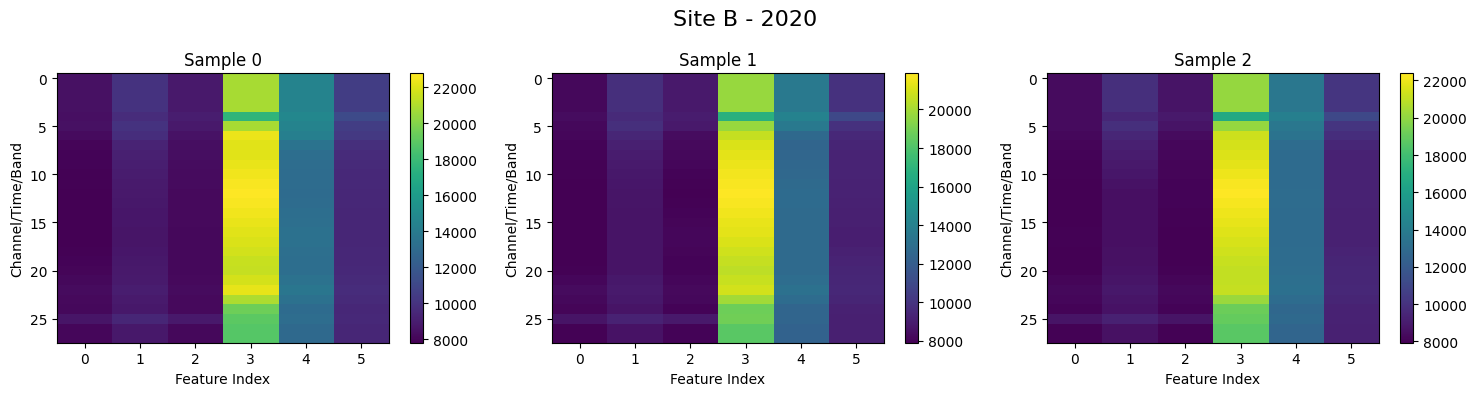

In [10]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


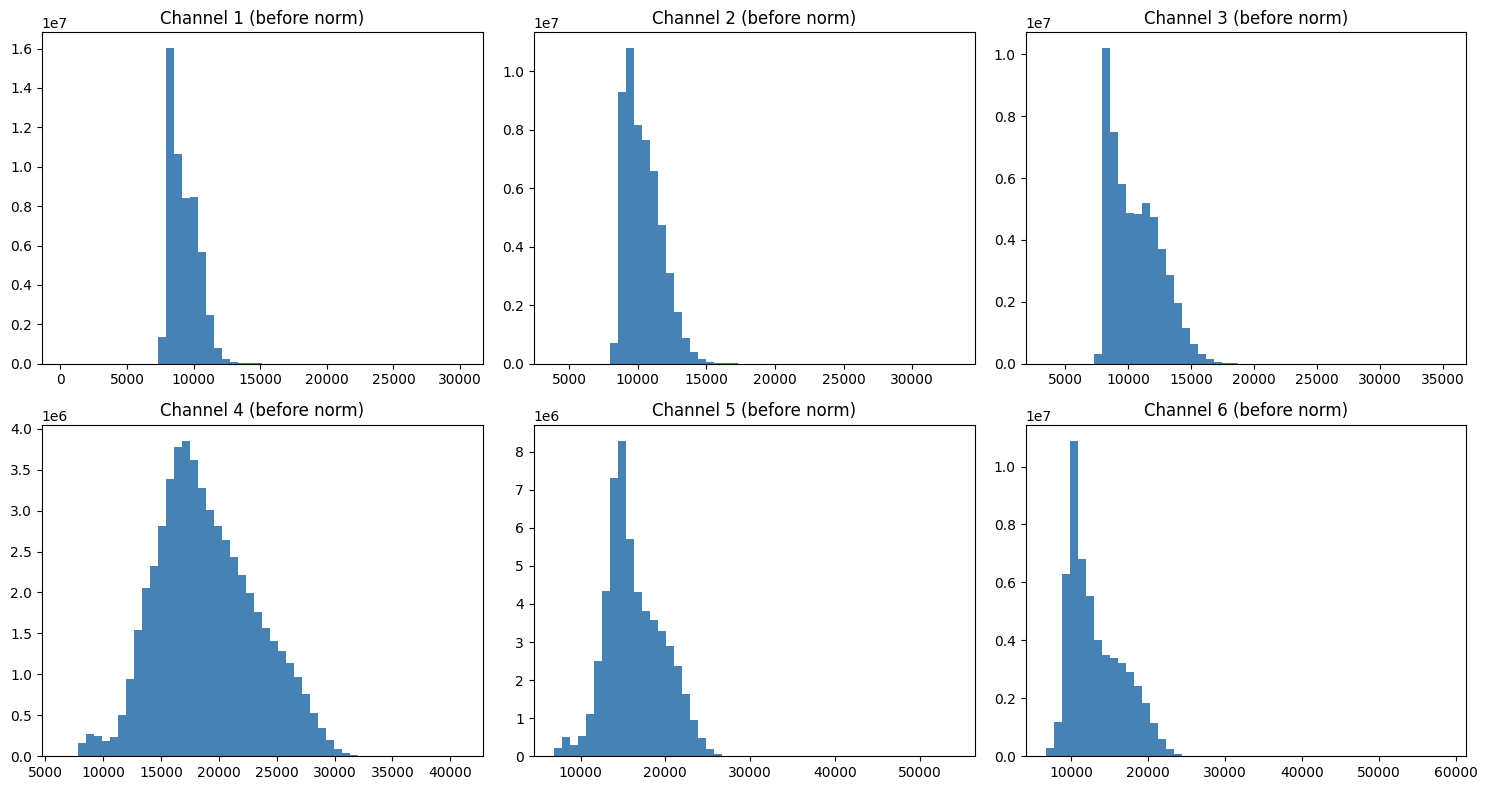

In [12]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [13]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

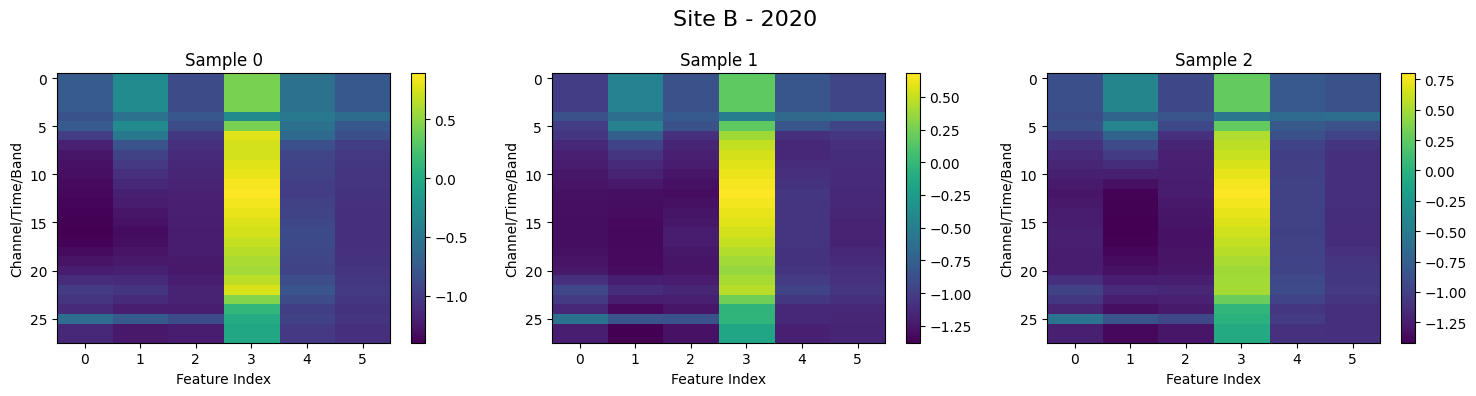

In [14]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


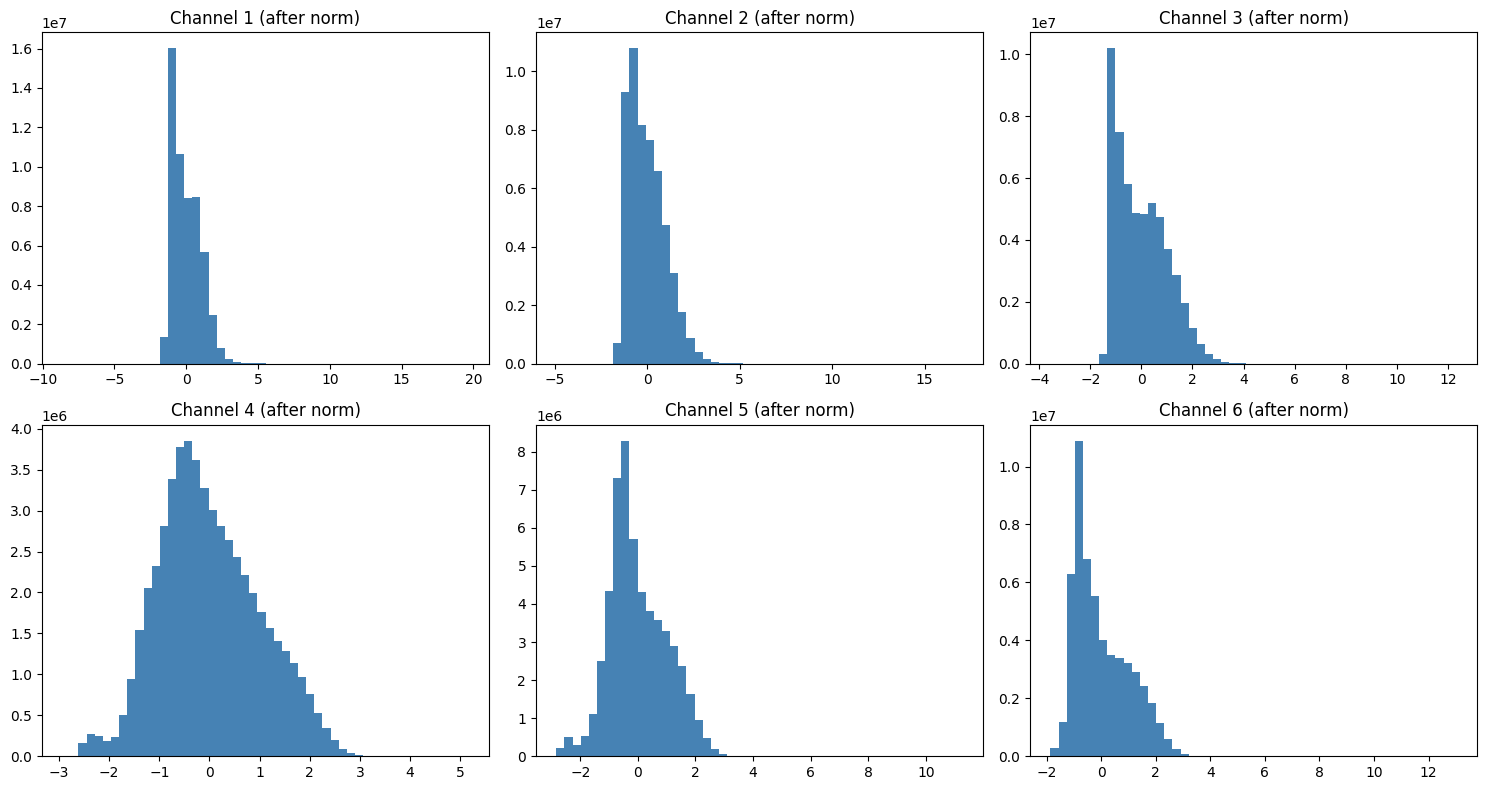

In [16]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


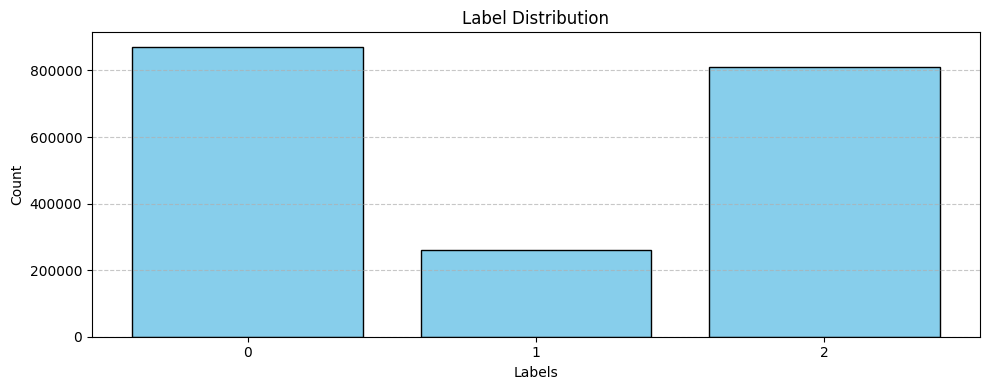

In [17]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [18]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [19]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [20]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


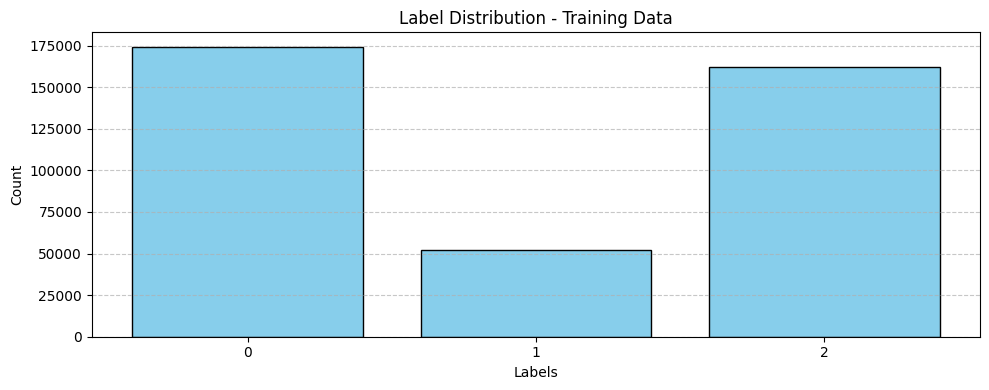

In [21]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [22]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [24]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.dropout = nn.Dropout(p=0.3)
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [25]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

## Evaluation Function

In [26]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [27]:
def evaluate(model, dataloader, class_weights=None, T=T, device=DEVICE):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0
    val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, kl = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Loss Calculation
            nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            loss = nll + KL_WEIGHT * kl
            val_loss += loss.item() * x_batch.size(0)
            

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    val_loss /= len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return val_loss, acc, kappa, per_class_f1, avg_f1, cm

## Acquisition Function

In [28]:
# ============= Predictive Entropy ============= 
def predictive_entropy_sampling(X, model, k, device, unlabeled_pool, T=T):
    model.eval()
    indices = list(unlabeled_pool)
    X_pool = X[indices]

    all_outputs = []
    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (PE)"):
            batch_outputs = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                batch = X_pool[i:i+BATCH_SIZE]
                x_tensor = torch.tensor(batch).float().permute(0, 2, 1).to(device)

                out, _ = model(x_tensor, sample=True)   # (B, C)
                batch_outputs.append(out)               # collect (B, C)

            # stack batches back together → (N, C)
            batch_outputs = torch.cat(batch_outputs, dim=0)
            all_outputs.append(batch_outputs.unsqueeze(0))  # (1, N, C)

    # stack across T → (T, N, C)
    outputs = torch.cat(all_outputs, dim=0)

    # softmax to get probs
    probs = F.softmax(outputs, dim=-1)  # (T, N, C)

    # predictive entropy
    avg_probs = probs.mean(dim=0)  # (N, C)
    entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)  # (N,)

    topk = torch.topk(entropy, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BALD (Bayesian AL by Disagreement) ============= 
def bald_sampling(X, model, k, device, unlabeled_pool, T=20):
    model.eval()
    indices = list(unlabeled_pool)
    X_pool = X[indices]

    all_outputs = []
    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (BALD)"):
            batch_outputs = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                batch = X_pool[i:i+BATCH_SIZE]
                x_tensor = torch.tensor(batch).float().permute(0, 2, 1).to(device)

                out, _ = model(x_tensor, sample=True)  # (B, C)
                batch_outputs.append(out)

            batch_outputs = torch.cat(batch_outputs, dim=0)  # (N, C)
            all_outputs.append(batch_outputs.unsqueeze(0))   # (1, N, C)

    outputs = torch.cat(all_outputs, dim=0)   # (T, N, C)
    probs = F.softmax(outputs, dim=-1)        # (T, N, C)

    avg_probs = probs.mean(dim=0)             # (N, C)

    # Predictive entropy
    H = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)  # (N,)

    # Expected entropy
    E_H = -torch.sum(probs * torch.log(probs + 1e-8), dim=2).mean(dim=0)  # (N,)

    bald_score = H - E_H
    topk = torch.topk(bald_score, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= Variation Ratios ============= 
def variation_ratio_sampling(X, model, k, device, unlabeled_pool, T=20):
    model.eval()
    indices = list(unlabeled_pool)
    X_pool = X[indices]

    all_preds = []
    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (VR)"):
            batch_preds = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                batch = X_pool[i:i+BATCH_SIZE]
                x_tensor = torch.tensor(batch).float().permute(0, 2, 1).to(device)

                out, _ = model(x_tensor, sample=True)     # (B, C)
                pred = torch.argmax(out, dim=-1)          # (B,)
                batch_preds.append(pred)

            batch_preds = torch.cat(batch_preds, dim=0)  # (N,)
            all_preds.append(batch_preds.unsqueeze(0))   # (1, N)

    preds = torch.cat(all_preds, dim=0)  # (T, N)

    mode_preds = torch.mode(preds, dim=0).values        # (N,)
    agreement = (preds == mode_preds.unsqueeze(0)).sum(dim=0)  # (N,)
    variation_ratio = 1 - agreement.float() / T         # (N,)

    topk = torch.topk(variation_ratio, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BvSB (Best vs Second Best) ============= 
def bvsb_sampling(X, model, k, device, unlabeled_pool, T=20):
    model.eval()
    indices = list(unlabeled_pool)
    X_pool = X[indices]

    all_outputs = []
    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (BvSB)"):
            batch_outputs = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                batch = X_pool[i:i+BATCH_SIZE]
                x_tensor = torch.tensor(batch).float().permute(0, 2, 1).to(device)

                out, _ = model(x_tensor, sample=True)  # (B, C)
                batch_outputs.append(out)

            batch_outputs = torch.cat(batch_outputs, dim=0)  # (N, C)
            all_outputs.append(batch_outputs.unsqueeze(0))   # (1, N, C)

    outputs = torch.cat(all_outputs, dim=0)  # (T, N, C)
    probs = F.softmax(outputs, dim=-1)       # (T, N, C)

    avg_probs = probs.mean(dim=0)            # (N, C)
    sorted_probs, _ = torch.sort(avg_probs, dim=1)  # (N, C)
    margins = sorted_probs[:, -1] - sorted_probs[:, -2]  # (N,)

    topk = torch.topk(-margins, k=k).indices  # smaller margin = more uncertainty
    return [indices[i.item()] for i in topk]

In [ ]:
# Remaining 2 strategies
sampling_strategies = {
    "predictive_entropy": predictive_entropy_sampling,
    "bald": bald_sampling,
    "variation_ratio": variation_ratio_sampling,
    "bvsb": bvsb_sampling
}

# Create separate pools and histories for each strategy
strategy_pools = {}
strategy_histories = {}

for name in sampling_strategies:
    strategy_pools[name] = {
        "labeled": set(),
        "unlabeled": set(range(len(X_train)))
    }
    
    strategy_histories[name] = {
        "rounds": [],
        "num_labeled": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "avg_f1": [],
        "per_class_f1": [],
        "kappa": []
    }

## Training Loop

In [30]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [31]:
# ===== Training Loop =====
def train(model, train_dataset, train_loader, optimizer, class_weights=None, KL_WEIGHT=1e-8, EPOCHS=15, T=15):
    train_losses, train_accs = [], []

    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)

        # Save stats
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT * kl}')
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}") 

    return train_losses, train_accs

## AL Pipeline Loop

In [32]:
# Calculate total and effective samples
total_samples = AL_ROUNDS * QUERY_SIZE + INITIAL_LABELED
effective_samples = INITIAL_LABELED * AL_ROUNDS + QUERY_SIZE * (AL_ROUNDS * (AL_ROUNDS + 1)) // 2  # Sum of 1+2+...+num_rounds

# Nicely formatted print
print("=" * 50)
print(" Active Learning Configuration Summary")
print("=" * 50)
print(f"Stochastic Passes:          {T}")
print(f"Number of Rounds:           {AL_ROUNDS}")
print(f"Initial Labeled Samples:    {INITIAL_LABELED}")
print(f"Query Size per Round:       {QUERY_SIZE}")
print(f"Number of epochs:           {EPOCHS}")
print(f"Total Labeled Samples:      {total_samples}")
print(f"Effective Samples (Total):  {effective_samples}")
print("=" * 50)

 Active Learning Configuration Summary
Stochastic Passes:          10
Number of Rounds:           10
Initial Labeled Samples:    4000
Query Size per Round:       1000
Number of epochs:           20
Total Labeled Samples:      14000
Effective Samples (Total):  95000



 Running strategy: VARIATION_RATIO 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 388743
Length of Labeled Pool: 4000
Length of Unlabeled Pool: 384743
Class weights: tensor([0.7550, 1.2500, 0.7974], device='cuda:0')

-> Training on 4000 initially labeled samples 


Training Epoch 1: 100%|██████████| 63/63 [00:02<00:00, 22.75it/s]


Loss: 0.3518 + 1e-08 * 2859660.25
Loss: 0.3518 + 0.028596602380275726
Epoch [1/20] Train Loss: 0.8850, Train Acc: 0.7085


Training Epoch 2: 100%|██████████| 63/63 [00:01<00:00, 42.75it/s]


Loss: 0.4793 + 1e-08 * 2849885.0
Loss: 0.4793 + 0.028498848900198936
Epoch [2/20] Train Loss: 0.5173, Train Acc: 0.8160


Training Epoch 3: 100%|██████████| 63/63 [00:01<00:00, 42.64it/s]


Loss: 0.4408 + 1e-08 * 2839561.75
Loss: 0.4408 + 0.02839561738073826
Epoch [3/20] Train Loss: 0.4496, Train Acc: 0.8415


Training Epoch 4: 100%|██████████| 63/63 [00:01<00:00, 42.61it/s]


Loss: 0.4303 + 1e-08 * 2828462.25
Loss: 0.4303 + 0.028284622356295586
Epoch [4/20] Train Loss: 0.4074, Train Acc: 0.8472


Training Epoch 5: 100%|██████████| 63/63 [00:01<00:00, 42.68it/s]


Loss: 0.3017 + 1e-08 * 2817065.25
Loss: 0.3017 + 0.02817065268754959
Epoch [5/20] Train Loss: 0.3737, Train Acc: 0.8648


Training Epoch 6: 100%|██████████| 63/63 [00:01<00:00, 42.42it/s]


Loss: 0.2083 + 1e-08 * 2805085.75
Loss: 0.2083 + 0.028050856664776802
Epoch [6/20] Train Loss: 0.3691, Train Acc: 0.8710


Training Epoch 7: 100%|██████████| 63/63 [00:01<00:00, 42.77it/s]


Loss: 0.1273 + 1e-08 * 2792538.75
Loss: 0.1273 + 0.027925387024879456
Epoch [7/20] Train Loss: 0.3522, Train Acc: 0.8738


Training Epoch 8: 100%|██████████| 63/63 [00:01<00:00, 43.11it/s]


Loss: 0.4133 + 1e-08 * 2779704.5
Loss: 0.4133 + 0.027797045186161995
Epoch [8/20] Train Loss: 0.3554, Train Acc: 0.8708


Training Epoch 9: 100%|██████████| 63/63 [00:01<00:00, 42.96it/s]


Loss: 0.2459 + 1e-08 * 2767701.0
Loss: 0.2459 + 0.027677010744810104
Epoch [9/20] Train Loss: 0.3359, Train Acc: 0.8770


Training Epoch 10: 100%|██████████| 63/63 [00:01<00:00, 42.95it/s]


Loss: 0.1684 + 1e-08 * 2754433.25
Loss: 0.1684 + 0.027544332668185234
Epoch [10/20] Train Loss: 0.3451, Train Acc: 0.8792


Training Epoch 11: 100%|██████████| 63/63 [00:01<00:00, 42.63it/s]


Loss: 0.8513 + 1e-08 * 2741933.25
Loss: 0.8513 + 0.027419332414865494
Epoch [11/20] Train Loss: 0.3357, Train Acc: 0.8765


Training Epoch 12: 100%|██████████| 63/63 [00:01<00:00, 43.06it/s]


Loss: 0.2951 + 1e-08 * 2731255.0
Loss: 0.2951 + 0.02731255069375038
Epoch [12/20] Train Loss: 0.3197, Train Acc: 0.8828


Training Epoch 13: 100%|██████████| 63/63 [00:01<00:00, 42.93it/s]


Loss: 0.2637 + 1e-08 * 2718626.75
Loss: 0.2637 + 0.02718626707792282
Epoch [13/20] Train Loss: 0.3078, Train Acc: 0.8872


Training Epoch 14: 100%|██████████| 63/63 [00:01<00:00, 43.00it/s]


Loss: 0.4627 + 1e-08 * 2707306.5
Loss: 0.4627 + 0.02707306481897831
Epoch [14/20] Train Loss: 0.3153, Train Acc: 0.8895


Training Epoch 15: 100%|██████████| 63/63 [00:01<00:00, 43.05it/s]


Loss: 0.3733 + 1e-08 * 2694934.75
Loss: 0.3733 + 0.02694934792816639
Epoch [15/20] Train Loss: 0.3091, Train Acc: 0.8905


Training Epoch 16: 100%|██████████| 63/63 [00:01<00:00, 43.07it/s]


Loss: 0.3423 + 1e-08 * 2685003.0
Loss: 0.3423 + 0.026850029826164246
Epoch [16/20] Train Loss: 0.3065, Train Acc: 0.8935


Training Epoch 17: 100%|██████████| 63/63 [00:01<00:00, 42.80it/s]


Loss: 0.2017 + 1e-08 * 2674095.0
Loss: 0.2017 + 0.026740949600934982
Epoch [17/20] Train Loss: 0.3018, Train Acc: 0.8885


Training Epoch 18: 100%|██████████| 63/63 [00:01<00:00, 43.04it/s]


Loss: 0.2676 + 1e-08 * 2663410.0
Loss: 0.2676 + 0.02663409896194935
Epoch [18/20] Train Loss: 0.2922, Train Acc: 0.8978


Training Epoch 19: 100%|██████████| 63/63 [00:01<00:00, 43.08it/s]


Loss: 0.4236 + 1e-08 * 2652577.25
Loss: 0.4236 + 0.026525773108005524
Epoch [19/20] Train Loss: 0.2811, Train Acc: 0.9012


Training Epoch 20: 100%|██████████| 63/63 [00:01<00:00, 43.36it/s]


Loss: 0.1747 + 1e-08 * 2643438.5
Loss: 0.1747 + 0.026434384286403656
Epoch [20/20] Train Loss: 0.2931, Train Acc: 0.8912


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 136.84it/s]


Per-class F1 scores: [0.88670177 0.89377181 0.89027543]
Validation Accuracy: 88.92%
Validation Loss: 0.3126
Average F1 Score: 0.8902
Kappa: 0.8181

--- Round 1 [variation_ratio] ---


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:30<00:00, 39.04s/it]


Length of Labeled Pool: 5000
Length of Unlabeled Pool: 383743


Training Epoch 1: 100%|██████████| 79/79 [00:01<00:00, 41.68it/s]


Loss: 0.7059 + 1e-08 * 2626449.25
Loss: 0.7059 + 0.0262644924223423
Epoch [1/20] Train Loss: 0.4276, Train Acc: 0.8156


Training Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 42.76it/s]


Loss: 0.6774 + 1e-08 * 2616355.25
Loss: 0.6774 + 0.026163551956415176
Epoch [2/20] Train Loss: 0.4220, Train Acc: 0.8166


Training Epoch 3: 100%|██████████| 79/79 [00:01<00:00, 43.12it/s]


Loss: 0.4452 + 1e-08 * 2605461.75
Loss: 0.4452 + 0.026054617017507553
Epoch [3/20] Train Loss: 0.4163, Train Acc: 0.8234


Training Epoch 4: 100%|██████████| 79/79 [00:01<00:00, 43.23it/s]


Loss: 0.5174 + 1e-08 * 2593520.0
Loss: 0.5174 + 0.025935199111700058
Epoch [4/20] Train Loss: 0.4073, Train Acc: 0.8308


Training Epoch 5: 100%|██████████| 79/79 [00:01<00:00, 43.01it/s]


Loss: 0.3230 + 1e-08 * 2582388.25
Loss: 0.3230 + 0.02582388184964657
Epoch [5/20] Train Loss: 0.4039, Train Acc: 0.8262


Training Epoch 6: 100%|██████████| 79/79 [00:01<00:00, 43.27it/s]


Loss: 0.4861 + 1e-08 * 2572017.25
Loss: 0.4861 + 0.025720171630382538
Epoch [6/20] Train Loss: 0.3852, Train Acc: 0.8330


Training Epoch 7: 100%|██████████| 79/79 [00:01<00:00, 43.20it/s]


Loss: 0.7887 + 1e-08 * 2561978.0
Loss: 0.7887 + 0.025619780644774437
Epoch [7/20] Train Loss: 0.3813, Train Acc: 0.8420


Training Epoch 8: 100%|██████████| 79/79 [00:01<00:00, 42.85it/s]


Loss: 0.1932 + 1e-08 * 2551765.25
Loss: 0.1932 + 0.025517651811242104
Epoch [8/20] Train Loss: 0.3862, Train Acc: 0.8408


Training Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 43.04it/s]


Loss: 0.3756 + 1e-08 * 2539825.0
Loss: 0.3756 + 0.02539825066924095
Epoch [9/20] Train Loss: 0.3792, Train Acc: 0.8354


Training Epoch 10: 100%|██████████| 79/79 [00:01<00:00, 43.01it/s]


Loss: 0.1381 + 1e-08 * 2529575.5
Loss: 0.1381 + 0.02529575489461422
Epoch [10/20] Train Loss: 0.3684, Train Acc: 0.8476


Training Epoch 11: 100%|██████████| 79/79 [00:01<00:00, 43.07it/s]


Loss: 0.1271 + 1e-08 * 2520567.0
Loss: 0.1271 + 0.025205669924616814
Epoch [11/20] Train Loss: 0.3678, Train Acc: 0.8426


Training Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 43.18it/s]


Loss: 1.0922 + 1e-08 * 2511071.25
Loss: 1.0922 + 0.02511071227490902
Epoch [12/20] Train Loss: 0.3676, Train Acc: 0.8472


Training Epoch 13: 100%|██████████| 79/79 [00:01<00:00, 42.65it/s]


Loss: 0.6574 + 1e-08 * 2504480.25
Loss: 0.6574 + 0.025044802576303482
Epoch [13/20] Train Loss: 0.3631, Train Acc: 0.8522


Training Epoch 14: 100%|██████████| 79/79 [00:01<00:00, 42.91it/s]


Loss: 0.3922 + 1e-08 * 2495754.0
Loss: 0.3922 + 0.02495753951370716
Epoch [14/20] Train Loss: 0.3599, Train Acc: 0.8470


Training Epoch 15: 100%|██████████| 79/79 [00:01<00:00, 43.11it/s]


Loss: 1.3919 + 1e-08 * 2491578.25
Loss: 1.3919 + 0.0249157827347517
Epoch [15/20] Train Loss: 0.3661, Train Acc: 0.8472


Training Epoch 16: 100%|██████████| 79/79 [00:01<00:00, 43.11it/s]


Loss: 0.5924 + 1e-08 * 2483556.75
Loss: 0.5924 + 0.02483556792140007
Epoch [16/20] Train Loss: 0.3508, Train Acc: 0.8516


Training Epoch 17: 100%|██████████| 79/79 [00:01<00:00, 43.09it/s]


Loss: 1.0600 + 1e-08 * 2476578.25
Loss: 1.0600 + 0.024765782058238983
Epoch [17/20] Train Loss: 0.3538, Train Acc: 0.8534


Training Epoch 18: 100%|██████████| 79/79 [00:01<00:00, 43.25it/s]


Loss: 0.3701 + 1e-08 * 2471305.75
Loss: 0.3701 + 0.02471305802464485
Epoch [18/20] Train Loss: 0.3600, Train Acc: 0.8512


Training Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 42.77it/s]


Loss: 0.1649 + 1e-08 * 2464395.5
Loss: 0.1649 + 0.024643955752253532
Epoch [19/20] Train Loss: 0.3532, Train Acc: 0.8554


Training Epoch 20: 100%|██████████| 79/79 [00:01<00:00, 43.10it/s]


Loss: 0.1048 + 1e-08 * 2457510.75
Loss: 0.1048 + 0.02457510679960251
Epoch [20/20] Train Loss: 0.3544, Train Acc: 0.8538


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.51it/s]


Per-class F1 scores: [0.89785189 0.90547863 0.8945427 ]
Validation Accuracy: 89.75%
Validation Loss: 0.2947
Average F1 Score: 0.8993
Kappa: 0.8314

--- Round 2 [variation_ratio] ---


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:29<00:00, 38.93s/it]


Length of Labeled Pool: 6000
Length of Unlabeled Pool: 382743


Training Epoch 1: 100%|██████████| 94/94 [00:02<00:00, 42.95it/s]


Loss: 0.4399 + 1e-08 * 2441593.25
Loss: 0.4399 + 0.024415932595729828
Epoch [1/20] Train Loss: 0.4477, Train Acc: 0.7968


Training Epoch 2: 100%|██████████| 94/94 [00:02<00:00, 42.93it/s]


Loss: 0.3786 + 1e-08 * 2432873.75
Loss: 0.3786 + 0.02432873658835888
Epoch [2/20] Train Loss: 0.4446, Train Acc: 0.8055


Training Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 42.65it/s]


Loss: 0.4649 + 1e-08 * 2424016.0
Loss: 0.4649 + 0.02424016036093235
Epoch [3/20] Train Loss: 0.4402, Train Acc: 0.8108


Training Epoch 4: 100%|██████████| 94/94 [00:02<00:00, 43.03it/s]


Loss: 0.2659 + 1e-08 * 2414849.5
Loss: 0.2659 + 0.024148494005203247
Epoch [4/20] Train Loss: 0.4217, Train Acc: 0.8123


Training Epoch 5: 100%|██████████| 94/94 [00:02<00:00, 43.06it/s]


Loss: 0.3331 + 1e-08 * 2406269.0
Loss: 0.3331 + 0.024062689393758774
Epoch [5/20] Train Loss: 0.4242, Train Acc: 0.8185


Training Epoch 6: 100%|██████████| 94/94 [00:02<00:00, 43.14it/s]


Loss: 0.4316 + 1e-08 * 2397500.75
Loss: 0.4316 + 0.023975007236003876
Epoch [6/20] Train Loss: 0.4260, Train Acc: 0.8145


Training Epoch 7: 100%|██████████| 94/94 [00:02<00:00, 42.98it/s]


Loss: 0.4409 + 1e-08 * 2387615.5
Loss: 0.4409 + 0.02387615479528904
Epoch [7/20] Train Loss: 0.4164, Train Acc: 0.8167


Training Epoch 8: 100%|██████████| 94/94 [00:02<00:00, 42.87it/s]


Loss: 0.3812 + 1e-08 * 2380243.0
Loss: 0.3812 + 0.02380242943763733
Epoch [8/20] Train Loss: 0.4143, Train Acc: 0.8197


Training Epoch 9: 100%|██████████| 94/94 [00:02<00:00, 42.90it/s]


Loss: 0.3412 + 1e-08 * 2373470.75
Loss: 0.3412 + 0.02373470738530159
Epoch [9/20] Train Loss: 0.4111, Train Acc: 0.8187


Training Epoch 10: 100%|██████████| 94/94 [00:02<00:00, 43.18it/s]


Loss: 0.2952 + 1e-08 * 2366490.25
Loss: 0.2952 + 0.02366490289568901
Epoch [10/20] Train Loss: 0.4076, Train Acc: 0.8227


Training Epoch 11: 100%|██████████| 94/94 [00:02<00:00, 42.77it/s]


Loss: 0.5905 + 1e-08 * 2359362.25
Loss: 0.5905 + 0.02359362319111824
Epoch [11/20] Train Loss: 0.4106, Train Acc: 0.8200


Training Epoch 12: 100%|██████████| 94/94 [00:02<00:00, 42.72it/s]


Loss: 0.4076 + 1e-08 * 2351810.25
Loss: 0.4076 + 0.02351810224354267
Epoch [12/20] Train Loss: 0.4021, Train Acc: 0.8273


Training Epoch 13: 100%|██████████| 94/94 [00:02<00:00, 42.56it/s]


Loss: 0.2997 + 1e-08 * 2346289.5
Loss: 0.2997 + 0.023462895303964615
Epoch [13/20] Train Loss: 0.4060, Train Acc: 0.8303


Training Epoch 14: 100%|██████████| 94/94 [00:02<00:00, 42.96it/s]


Loss: 0.3834 + 1e-08 * 2341447.0
Loss: 0.3834 + 0.02341447025537491
Epoch [14/20] Train Loss: 0.3847, Train Acc: 0.8390


Training Epoch 15: 100%|██████████| 94/94 [00:02<00:00, 42.88it/s]


Loss: 0.4817 + 1e-08 * 2334676.25
Loss: 0.4817 + 0.023346763104200363
Epoch [15/20] Train Loss: 0.3852, Train Acc: 0.8393


Training Epoch 16: 100%|██████████| 94/94 [00:02<00:00, 43.01it/s]


Loss: 0.5309 + 1e-08 * 2327249.75
Loss: 0.5309 + 0.023272497579455376
Epoch [16/20] Train Loss: 0.3846, Train Acc: 0.8342


Training Epoch 17: 100%|██████████| 94/94 [00:02<00:00, 42.65it/s]


Loss: 0.3744 + 1e-08 * 2321867.0
Loss: 0.3744 + 0.02321866899728775
Epoch [17/20] Train Loss: 0.3879, Train Acc: 0.8317


Training Epoch 18: 100%|██████████| 94/94 [00:02<00:00, 42.99it/s]


Loss: 0.3918 + 1e-08 * 2317593.0
Loss: 0.3918 + 0.023175930604338646
Epoch [18/20] Train Loss: 0.3838, Train Acc: 0.8433


Training Epoch 19: 100%|██████████| 94/94 [00:02<00:00, 42.93it/s]


Loss: 0.3430 + 1e-08 * 2313893.5
Loss: 0.3430 + 0.02313893474638462
Epoch [19/20] Train Loss: 0.3805, Train Acc: 0.8405


Training Epoch 20: 100%|██████████| 94/94 [00:02<00:00, 42.93it/s]


Loss: 0.3405 + 1e-08 * 2307939.25
Loss: 0.3405 + 0.023079391568899155
Epoch [20/20] Train Loss: 0.3737, Train Acc: 0.8375


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:10<00:00, 138.24it/s]


Per-class F1 scores: [0.90292835 0.90951821 0.89921722]
Validation Accuracy: 90.23%
Validation Loss: 0.2930
Average F1 Score: 0.9039
Kappa: 0.8391

--- Round 3 [variation_ratio] ---


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:28<00:00, 38.80s/it]


Length of Labeled Pool: 7000
Length of Unlabeled Pool: 381743


Training Epoch 1: 100%|██████████| 110/110 [00:02<00:00, 42.93it/s]


Loss: 0.7493 + 1e-08 * 2293748.0
Loss: 0.7493 + 0.022937480360269547
Epoch [1/20] Train Loss: 0.4649, Train Acc: 0.7984


Training Epoch 2: 100%|██████████| 110/110 [00:02<00:00, 42.81it/s]


Loss: 0.3299 + 1e-08 * 2284823.0
Loss: 0.3299 + 0.022848229855298996
Epoch [2/20] Train Loss: 0.4549, Train Acc: 0.7979


Training Epoch 3: 100%|██████████| 110/110 [00:02<00:00, 42.92it/s]


Loss: 0.3399 + 1e-08 * 2276184.25
Loss: 0.3399 + 0.022761842235922813
Epoch [3/20] Train Loss: 0.4559, Train Acc: 0.7999


Training Epoch 4: 100%|██████████| 110/110 [00:02<00:00, 43.11it/s]


Loss: 0.2006 + 1e-08 * 2268197.25
Loss: 0.2006 + 0.02268197201192379
Epoch [4/20] Train Loss: 0.4465, Train Acc: 0.8033


Training Epoch 5: 100%|██████████| 110/110 [00:02<00:00, 43.19it/s]


Loss: 0.3606 + 1e-08 * 2260945.25
Loss: 0.3606 + 0.022609451785683632
Epoch [5/20] Train Loss: 0.4491, Train Acc: 0.8066


Training Epoch 6: 100%|██████████| 110/110 [00:02<00:00, 42.60it/s]


Loss: 0.3001 + 1e-08 * 2254744.75
Loss: 0.3001 + 0.022547448053956032
Epoch [6/20] Train Loss: 0.4438, Train Acc: 0.8067


Training Epoch 7: 100%|██████████| 110/110 [00:02<00:00, 43.16it/s]


Loss: 0.5550 + 1e-08 * 2247702.5
Loss: 0.5550 + 0.022477025166153908
Epoch [7/20] Train Loss: 0.4383, Train Acc: 0.8093


Training Epoch 8: 100%|██████████| 110/110 [00:02<00:00, 43.14it/s]


Loss: 0.7041 + 1e-08 * 2241430.5
Loss: 0.7041 + 0.022414304316043854
Epoch [8/20] Train Loss: 0.4400, Train Acc: 0.8069


Training Epoch 9: 100%|██████████| 110/110 [00:02<00:00, 43.04it/s]


Loss: 0.4230 + 1e-08 * 2236542.5
Loss: 0.4230 + 0.022365424782037735
Epoch [9/20] Train Loss: 0.4313, Train Acc: 0.8143


Training Epoch 10: 100%|██████████| 110/110 [00:02<00:00, 42.68it/s]


Loss: 0.3071 + 1e-08 * 2231262.5
Loss: 0.3071 + 0.022312624379992485
Epoch [10/20] Train Loss: 0.4260, Train Acc: 0.8151


Training Epoch 11: 100%|██████████| 110/110 [00:02<00:00, 42.86it/s]


Loss: 0.2052 + 1e-08 * 2226816.75
Loss: 0.2052 + 0.02226816676557064
Epoch [11/20] Train Loss: 0.4304, Train Acc: 0.8089


Training Epoch 12: 100%|██████████| 110/110 [00:02<00:00, 42.86it/s]


Loss: 0.2931 + 1e-08 * 2221339.75
Loss: 0.2931 + 0.022213397547602654
Epoch [12/20] Train Loss: 0.4212, Train Acc: 0.8179


Training Epoch 13: 100%|██████████| 110/110 [00:02<00:00, 42.67it/s]


Loss: 0.3486 + 1e-08 * 2216326.0
Loss: 0.3486 + 0.022163260728120804
Epoch [13/20] Train Loss: 0.4254, Train Acc: 0.8161


Training Epoch 14: 100%|██████████| 110/110 [00:02<00:00, 42.90it/s]


Loss: 0.2578 + 1e-08 * 2212466.5
Loss: 0.2578 + 0.02212466485798359
Epoch [14/20] Train Loss: 0.4135, Train Acc: 0.8220


Training Epoch 15: 100%|██████████| 110/110 [00:02<00:00, 42.96it/s]


Loss: 0.4207 + 1e-08 * 2205771.5
Loss: 0.4207 + 0.02205771394073963
Epoch [15/20] Train Loss: 0.4146, Train Acc: 0.8187


Training Epoch 16: 100%|██████████| 110/110 [00:02<00:00, 42.81it/s]


Loss: 0.6607 + 1e-08 * 2203552.75
Loss: 0.6607 + 0.02203552797436714
Epoch [16/20] Train Loss: 0.4101, Train Acc: 0.8269


Training Epoch 17: 100%|██████████| 110/110 [00:02<00:00, 42.75it/s]


Loss: 0.5725 + 1e-08 * 2198766.0
Loss: 0.5725 + 0.021987659856677055
Epoch [17/20] Train Loss: 0.4038, Train Acc: 0.8244


Training Epoch 18: 100%|██████████| 110/110 [00:02<00:00, 43.03it/s]


Loss: 0.4159 + 1e-08 * 2192762.75
Loss: 0.4159 + 0.02192762680351734
Epoch [18/20] Train Loss: 0.4069, Train Acc: 0.8199


Training Epoch 19: 100%|██████████| 110/110 [00:02<00:00, 43.19it/s]


Loss: 0.3904 + 1e-08 * 2187531.0
Loss: 0.3904 + 0.02187531068921089
Epoch [19/20] Train Loss: 0.4030, Train Acc: 0.8270


Training Epoch 20: 100%|██████████| 110/110 [00:02<00:00, 43.18it/s]


Loss: 0.3705 + 1e-08 * 2181901.75
Loss: 0.3705 + 0.021819017827510834
Epoch [20/20] Train Loss: 0.3909, Train Acc: 0.8349


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.09it/s]


Per-class F1 scores: [0.90309518 0.91037521 0.89992387]
Validation Accuracy: 90.28%
Validation Loss: 0.2903
Average F1 Score: 0.9045
Kappa: 0.8399

--- Round 4 [variation_ratio] ---


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:28<00:00, 38.80s/it]


Length of Labeled Pool: 8000
Length of Unlabeled Pool: 380743


Training Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 42.60it/s]


Loss: 0.5034 + 1e-08 * 2169831.25
Loss: 0.5034 + 0.02169831283390522
Epoch [1/20] Train Loss: 0.4848, Train Acc: 0.7866


Training Epoch 2: 100%|██████████| 125/125 [00:02<00:00, 42.74it/s]


Loss: 0.4962 + 1e-08 * 2162647.75
Loss: 0.4962 + 0.02162647806107998
Epoch [2/20] Train Loss: 0.4697, Train Acc: 0.7934


Training Epoch 3: 100%|██████████| 125/125 [00:02<00:00, 41.84it/s]


Loss: 0.3826 + 1e-08 * 2155415.75
Loss: 0.3826 + 0.02155415713787079
Epoch [3/20] Train Loss: 0.4686, Train Acc: 0.7913


Training Epoch 4: 100%|██████████| 125/125 [00:02<00:00, 42.83it/s]


Loss: 0.3311 + 1e-08 * 2151168.25
Loss: 0.3311 + 0.021511683240532875
Epoch [4/20] Train Loss: 0.4576, Train Acc: 0.7946


Training Epoch 5: 100%|██████████| 125/125 [00:02<00:00, 42.62it/s]


Loss: 0.3992 + 1e-08 * 2145094.5
Loss: 0.3992 + 0.021450944244861603
Epoch [5/20] Train Loss: 0.4596, Train Acc: 0.7985


Training Epoch 6: 100%|██████████| 125/125 [00:02<00:00, 42.52it/s]


Loss: 0.4849 + 1e-08 * 2139387.25
Loss: 0.4849 + 0.021393872797489166
Epoch [6/20] Train Loss: 0.4488, Train Acc: 0.8009


Training Epoch 7: 100%|██████████| 125/125 [00:02<00:00, 42.82it/s]


Loss: 0.6269 + 1e-08 * 2135616.0
Loss: 0.6269 + 0.021356159821152687
Epoch [7/20] Train Loss: 0.4540, Train Acc: 0.7986


Training Epoch 8: 100%|██████████| 125/125 [00:02<00:00, 42.78it/s]


Loss: 0.4356 + 1e-08 * 2129866.5
Loss: 0.4356 + 0.021298665553331375
Epoch [8/20] Train Loss: 0.4435, Train Acc: 0.8104


Training Epoch 9: 100%|██████████| 125/125 [00:02<00:00, 42.94it/s]


Loss: 0.5090 + 1e-08 * 2126689.75
Loss: 0.5090 + 0.02126689814031124
Epoch [9/20] Train Loss: 0.4505, Train Acc: 0.7994


Training Epoch 10: 100%|██████████| 125/125 [00:02<00:00, 42.96it/s]


Loss: 0.6692 + 1e-08 * 2122574.0
Loss: 0.6692 + 0.021225739270448685
Epoch [10/20] Train Loss: 0.4397, Train Acc: 0.8126


Training Epoch 11: 100%|██████████| 125/125 [00:02<00:00, 42.86it/s]


Loss: 0.3193 + 1e-08 * 2118958.5
Loss: 0.3193 + 0.021189585328102112
Epoch [11/20] Train Loss: 0.4343, Train Acc: 0.8127


Training Epoch 12: 100%|██████████| 125/125 [00:02<00:00, 42.86it/s]


Loss: 0.4909 + 1e-08 * 2117570.75
Loss: 0.4909 + 0.021175706759095192
Epoch [12/20] Train Loss: 0.4404, Train Acc: 0.8145


Training Epoch 13: 100%|██████████| 125/125 [00:02<00:00, 42.86it/s]


Loss: 0.3398 + 1e-08 * 2113030.75
Loss: 0.3398 + 0.021130306646227837
Epoch [13/20] Train Loss: 0.4289, Train Acc: 0.8085


Training Epoch 14: 100%|██████████| 125/125 [00:02<00:00, 43.16it/s]


Loss: 0.3300 + 1e-08 * 2110095.75
Loss: 0.3300 + 0.021100956946611404
Epoch [14/20] Train Loss: 0.4190, Train Acc: 0.8166


Training Epoch 15: 100%|██████████| 125/125 [00:02<00:00, 42.80it/s]


Loss: 0.5406 + 1e-08 * 2108648.0
Loss: 0.5406 + 0.02108648046851158
Epoch [15/20] Train Loss: 0.4238, Train Acc: 0.8179


Training Epoch 16: 100%|██████████| 125/125 [00:02<00:00, 42.88it/s]


Loss: 0.3934 + 1e-08 * 2107232.75
Loss: 0.3934 + 0.021072328090667725
Epoch [16/20] Train Loss: 0.4260, Train Acc: 0.8144


Training Epoch 17: 100%|██████████| 125/125 [00:02<00:00, 43.09it/s]


Loss: 0.4558 + 1e-08 * 2104383.0
Loss: 0.4558 + 0.02104382961988449
Epoch [17/20] Train Loss: 0.4209, Train Acc: 0.8233


Training Epoch 18: 100%|██████████| 125/125 [00:02<00:00, 43.03it/s]


Loss: 0.3187 + 1e-08 * 2102238.0
Loss: 0.3187 + 0.021022379398345947
Epoch [18/20] Train Loss: 0.4255, Train Acc: 0.8174


Training Epoch 19: 100%|██████████| 125/125 [00:02<00:00, 42.90it/s]


Loss: 0.6006 + 1e-08 * 2099162.25
Loss: 0.6006 + 0.020991621538996696
Epoch [19/20] Train Loss: 0.4211, Train Acc: 0.8231


Training Epoch 20: 100%|██████████| 125/125 [00:02<00:00, 43.19it/s]


Loss: 0.5464 + 1e-08 * 2095592.625
Loss: 0.5464 + 0.020955925807356834
Epoch [20/20] Train Loss: 0.4099, Train Acc: 0.8265


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:10<00:00, 138.60it/s]


Per-class F1 scores: [0.90588825 0.91004734 0.90268784]
Validation Accuracy: 90.51%
Validation Loss: 0.2888
Average F1 Score: 0.9062
Kappa: 0.8440

--- Round 5 [variation_ratio] ---


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:25<00:00, 38.50s/it]


Length of Labeled Pool: 9000
Length of Unlabeled Pool: 379743


Training Epoch 1: 100%|██████████| 141/141 [00:03<00:00, 43.07it/s]


Loss: 0.5670 + 1e-08 * 2085433.125
Loss: 0.5670 + 0.02085433155298233
Epoch [1/20] Train Loss: 0.4946, Train Acc: 0.7772


Training Epoch 2: 100%|██████████| 141/141 [00:03<00:00, 42.95it/s]


Loss: 0.4127 + 1e-08 * 2079622.25
Loss: 0.4127 + 0.020796222612261772
Epoch [2/20] Train Loss: 0.4686, Train Acc: 0.7919


Training Epoch 3: 100%|██████████| 141/141 [00:03<00:00, 42.71it/s]


Loss: 0.4416 + 1e-08 * 2075065.5
Loss: 0.4416 + 0.020750654861330986
Epoch [3/20] Train Loss: 0.4750, Train Acc: 0.7872


Training Epoch 4: 100%|██████████| 141/141 [00:03<00:00, 43.15it/s]


Loss: 0.3496 + 1e-08 * 2070946.375
Loss: 0.3496 + 0.020709464326500893
Epoch [4/20] Train Loss: 0.4644, Train Acc: 0.7956


Training Epoch 5: 100%|██████████| 141/141 [00:03<00:00, 43.12it/s]


Loss: 0.5160 + 1e-08 * 2066087.5
Loss: 0.5160 + 0.020660875365138054
Epoch [5/20] Train Loss: 0.4643, Train Acc: 0.7954


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:26<00:00, 38.61s/it]


Length of Labeled Pool: 10000
Length of Unlabeled Pool: 378743


Training Epoch 1: 100%|██████████| 157/157 [00:03<00:00, 41.81it/s]


Loss: 0.2397 + 1e-08 * 2019004.125
Loss: 0.2397 + 0.0201900415122509
Epoch [1/20] Train Loss: 0.4976, Train Acc: 0.7791


Training Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 41.50it/s]


Loss: 0.4229 + 1e-08 * 2014018.25
Loss: 0.4229 + 0.020140182226896286
Epoch [2/20] Train Loss: 0.4880, Train Acc: 0.7837


Training Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 41.69it/s]


Loss: 0.6171 + 1e-08 * 2010475.0
Loss: 0.6171 + 0.020104749128222466
Epoch [3/20] Train Loss: 0.4809, Train Acc: 0.7871


Training Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 41.63it/s]


Loss: 0.5185 + 1e-08 * 2006849.5
Loss: 0.5185 + 0.020068494603037834
Epoch [4/20] Train Loss: 0.4811, Train Acc: 0.7871


Training Epoch 5: 100%|██████████| 157/157 [00:03<00:00, 41.59it/s]


Loss: 1.1467 + 1e-08 * 2003733.5
Loss: 1.1467 + 0.02003733441233635
Epoch [5/20] Train Loss: 0.4803, Train Acc: 0.7889


Training Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 41.58it/s]


Loss: 0.3317 + 1e-08 * 2000986.0
Loss: 0.3317 + 0.020009860396385193
Epoch [6/20] Train Loss: 0.4697, Train Acc: 0.7925


Training Epoch 7: 100%|██████████| 157/157 [00:03<00:00, 41.44it/s]


Loss: 0.3123 + 1e-08 * 1997749.875
Loss: 0.3123 + 0.019977498799562454
Epoch [7/20] Train Loss: 0.4750, Train Acc: 0.7904


Training Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 41.72it/s]


Loss: 0.6434 + 1e-08 * 1994086.0
Loss: 0.6434 + 0.01994086056947708
Epoch [8/20] Train Loss: 0.4663, Train Acc: 0.7985


Training Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 41.58it/s]


Loss: 0.2913 + 1e-08 * 1991567.0
Loss: 0.2913 + 0.019915670156478882
Epoch [9/20] Train Loss: 0.4618, Train Acc: 0.7991


Training Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 41.51it/s]


Loss: 0.3713 + 1e-08 * 1990138.375
Loss: 0.3713 + 0.01990138366818428
Epoch [10/20] Train Loss: 0.4678, Train Acc: 0.7950


Training Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 41.68it/s]


Loss: 0.3671 + 1e-08 * 1988804.375
Loss: 0.3671 + 0.01988804340362549
Epoch [11/20] Train Loss: 0.4554, Train Acc: 0.8027


Training Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 41.47it/s]


Loss: 0.3022 + 1e-08 * 1988249.25
Loss: 0.3022 + 0.01988249272108078
Epoch [12/20] Train Loss: 0.4606, Train Acc: 0.8000


Training Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 41.27it/s]


Loss: 0.6240 + 1e-08 * 1987143.125
Loss: 0.6240 + 0.019871430471539497
Epoch [13/20] Train Loss: 0.4600, Train Acc: 0.7982


Training Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 40.89it/s]


Loss: 0.2701 + 1e-08 * 1985013.5
Loss: 0.2701 + 0.01985013484954834
Epoch [14/20] Train Loss: 0.4543, Train Acc: 0.8024


Training Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 41.27it/s]


Loss: 0.4931 + 1e-08 * 1983390.25
Loss: 0.4931 + 0.019833901897072792
Epoch [15/20] Train Loss: 0.4560, Train Acc: 0.7998


Training Epoch 16: 100%|██████████| 157/157 [00:03<00:00, 41.54it/s]


Loss: 0.4013 + 1e-08 * 1983834.625
Loss: 0.4013 + 0.019838346168398857
Epoch [16/20] Train Loss: 0.4510, Train Acc: 0.8029


Training Epoch 17: 100%|██████████| 157/157 [00:03<00:00, 41.88it/s]


Loss: 0.3133 + 1e-08 * 1981332.125
Loss: 0.3133 + 0.01981332153081894
Epoch [17/20] Train Loss: 0.4507, Train Acc: 0.8078


Training Epoch 18: 100%|██████████| 157/157 [00:03<00:00, 41.74it/s]


Loss: 0.3363 + 1e-08 * 1979686.0
Loss: 0.3363 + 0.019796859472990036
Epoch [18/20] Train Loss: 0.4449, Train Acc: 0.8073


Training Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 40.04it/s]


Loss: 0.4942 + 1e-08 * 1979555.5
Loss: 0.4942 + 0.019795555621385574
Epoch [19/20] Train Loss: 0.4488, Train Acc: 0.8039


Training Epoch 20: 100%|██████████| 157/157 [00:03<00:00, 41.49it/s]


Loss: 0.3820 + 1e-08 * 1978994.25
Loss: 0.3820 + 0.019789941608905792
Epoch [20/20] Train Loss: 0.4359, Train Acc: 0.8091


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 134.55it/s]


Per-class F1 scores: [0.90588047 0.90939318 0.90254731]
Validation Accuracy: 90.50%
Validation Loss: 0.2955
Average F1 Score: 0.9059
Kappa: 0.8437

--- Round 7 [variation_ratio] ---


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:27<00:00, 38.71s/it]


Length of Labeled Pool: 11000
Length of Unlabeled Pool: 377743


Training Epoch 1: 100%|██████████| 172/172 [00:04<00:00, 42.42it/s]


Loss: 0.5753 + 1e-08 * 1973404.875
Loss: 0.5753 + 0.01973404921591282
Epoch [1/20] Train Loss: 0.5032, Train Acc: 0.7792


Training Epoch 2: 100%|██████████| 172/172 [00:04<00:00, 42.84it/s]


Loss: 0.4504 + 1e-08 * 1968478.25
Loss: 0.4504 + 0.01968478225171566
Epoch [2/20] Train Loss: 0.4830, Train Acc: 0.7882


Training Epoch 3: 100%|██████████| 172/172 [00:04<00:00, 42.74it/s]


Loss: 0.4230 + 1e-08 * 1965136.5
Loss: 0.4230 + 0.019651364535093307
Epoch [3/20] Train Loss: 0.4823, Train Acc: 0.7874


Training Epoch 4: 100%|██████████| 172/172 [00:04<00:00, 42.81it/s]


Loss: 0.3706 + 1e-08 * 1962922.375
Loss: 0.3706 + 0.0196292232722044
Epoch [4/20] Train Loss: 0.4810, Train Acc: 0.7913


Training Epoch 5: 100%|██████████| 172/172 [00:04<00:00, 42.75it/s]


Loss: 0.4945 + 1e-08 * 1960313.75
Loss: 0.4945 + 0.01960313692688942
Epoch [5/20] Train Loss: 0.4897, Train Acc: 0.7827


Training Epoch 6: 100%|██████████| 172/172 [00:04<00:00, 42.57it/s]


Loss: 0.5599 + 1e-08 * 1958878.5
Loss: 0.5599 + 0.019588785246014595
Epoch [6/20] Train Loss: 0.4824, Train Acc: 0.7851


Training Epoch 7: 100%|██████████| 172/172 [00:04<00:00, 42.57it/s]


Loss: 0.4951 + 1e-08 * 1957026.375
Loss: 0.4951 + 0.019570263102650642
Epoch [7/20] Train Loss: 0.4711, Train Acc: 0.7955


Training Epoch 8: 100%|██████████| 172/172 [00:04<00:00, 42.43it/s]


Loss: 0.4850 + 1e-08 * 1955425.375
Loss: 0.4850 + 0.019554253667593002
Epoch [8/20] Train Loss: 0.4653, Train Acc: 0.7982


Training Epoch 9: 100%|██████████| 172/172 [00:04<00:00, 42.75it/s]


Loss: 0.4875 + 1e-08 * 1955416.875
Loss: 0.4875 + 0.019554167985916138
Epoch [9/20] Train Loss: 0.4741, Train Acc: 0.7940


Training Epoch 10: 100%|██████████| 172/172 [00:04<00:00, 42.56it/s]


Loss: 0.3343 + 1e-08 * 1953934.75
Loss: 0.3343 + 0.019539346918463707
Epoch [10/20] Train Loss: 0.4647, Train Acc: 0.8021


Training Epoch 11: 100%|██████████| 172/172 [00:04<00:00, 42.53it/s]


Loss: 0.5662 + 1e-08 * 1952402.0
Loss: 0.5662 + 0.019524019211530685
Epoch [11/20] Train Loss: 0.4685, Train Acc: 0.7932


Training Epoch 12: 100%|██████████| 172/172 [00:04<00:00, 42.85it/s]


Loss: 0.3990 + 1e-08 * 1953654.0
Loss: 0.3990 + 0.019536539912223816
Epoch [12/20] Train Loss: 0.4703, Train Acc: 0.7927


Training Epoch 13: 100%|██████████| 172/172 [00:04<00:00, 42.68it/s]


Loss: 0.4380 + 1e-08 * 1954218.375
Loss: 0.4380 + 0.019542183727025986
Epoch [13/20] Train Loss: 0.4643, Train Acc: 0.7920


Training Epoch 14: 100%|██████████| 172/172 [00:04<00:00, 42.94it/s]


Loss: 0.4807 + 1e-08 * 1952453.625
Loss: 0.4807 + 0.01952453702688217
Epoch [14/20] Train Loss: 0.4561, Train Acc: 0.7990


Training Epoch 15: 100%|██████████| 172/172 [00:04<00:00, 42.79it/s]


Loss: 0.6068 + 1e-08 * 1952291.625
Loss: 0.6068 + 0.01952291652560234
Epoch [15/20] Train Loss: 0.4669, Train Acc: 0.7942


Training Epoch 16: 100%|██████████| 172/172 [00:04<00:00, 42.42it/s]


Loss: 0.5194 + 1e-08 * 1951312.125
Loss: 0.5194 + 0.019513120874762535
Epoch [16/20] Train Loss: 0.4651, Train Acc: 0.7958


Training Epoch 17: 100%|██████████| 172/172 [00:04<00:00, 42.57it/s]


Loss: 0.4644 + 1e-08 * 1950570.125
Loss: 0.4644 + 0.019505701959133148
Epoch [17/20] Train Loss: 0.4647, Train Acc: 0.7948


Training Epoch 18: 100%|██████████| 172/172 [00:04<00:00, 42.70it/s]


Loss: 0.5449 + 1e-08 * 1950661.5
Loss: 0.5449 + 0.01950661465525627
Epoch [18/20] Train Loss: 0.4570, Train Acc: 0.8007


Training Epoch 19: 100%|██████████| 172/172 [00:04<00:00, 42.70it/s]


Loss: 0.3439 + 1e-08 * 1949586.125
Loss: 0.3439 + 0.01949586160480976
Epoch [19/20] Train Loss: 0.4500, Train Acc: 0.8068


Training Epoch 20: 100%|██████████| 172/172 [00:04<00:00, 42.92it/s]


Loss: 0.3344 + 1e-08 * 1949047.5
Loss: 0.3344 + 0.019490474835038185
Epoch [20/20] Train Loss: 0.4426, Train Acc: 0.8066


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.44it/s]


Per-class F1 scores: [0.90780531 0.91551342 0.90474187]
Validation Accuracy: 90.76%
Validation Loss: 0.2863
Average F1 Score: 0.9094
Kappa: 0.8477

--- Round 8 [variation_ratio] ---


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:24<00:00, 38.48s/it]


Length of Labeled Pool: 12000
Length of Unlabeled Pool: 376743


Training Epoch 1: 100%|██████████| 188/188 [00:04<00:00, 42.47it/s]


Loss: 0.5775 + 1e-08 * 1941853.75
Loss: 0.5775 + 0.019418537616729736
Epoch [1/20] Train Loss: 0.4969, Train Acc: 0.7808


Training Epoch 2: 100%|██████████| 188/188 [00:04<00:00, 42.09it/s]


Loss: 0.3740 + 1e-08 * 1939682.875
Loss: 0.3740 + 0.01939682848751545
Epoch [2/20] Train Loss: 0.4921, Train Acc: 0.7797


Training Epoch 3: 100%|██████████| 188/188 [00:04<00:00, 42.21it/s]


Loss: 0.3740 + 1e-08 * 1938230.875
Loss: 0.3740 + 0.019382309168577194
Epoch [3/20] Train Loss: 0.4918, Train Acc: 0.7837


Training Epoch 4: 100%|██████████| 188/188 [00:04<00:00, 41.96it/s]


Loss: 0.6583 + 1e-08 * 1936086.625
Loss: 0.6583 + 0.019360866397619247
Epoch [4/20] Train Loss: 0.4811, Train Acc: 0.7889


Training Epoch 5: 100%|██████████| 188/188 [00:04<00:00, 42.30it/s]


Loss: 0.5749 + 1e-08 * 1933530.125
Loss: 0.5749 + 0.019335301592946053
Epoch [5/20] Train Loss: 0.4817, Train Acc: 0.7883


Training Epoch 6: 100%|██████████| 188/188 [00:04<00:00, 42.10it/s]


Loss: 0.5233 + 1e-08 * 1933076.125
Loss: 0.5233 + 0.019330760464072227
Epoch [6/20] Train Loss: 0.4790, Train Acc: 0.7844


Training Epoch 7: 100%|██████████| 188/188 [00:04<00:00, 42.24it/s]


Loss: 0.3799 + 1e-08 * 1933137.5
Loss: 0.3799 + 0.019331375136971474
Epoch [7/20] Train Loss: 0.4944, Train Acc: 0.7821


Training Epoch 8: 100%|██████████| 188/188 [00:04<00:00, 42.24it/s]


Loss: 0.4178 + 1e-08 * 1931490.0
Loss: 0.4178 + 0.019314900040626526
Epoch [8/20] Train Loss: 0.4736, Train Acc: 0.7942


Training Epoch 9: 100%|██████████| 188/188 [00:04<00:00, 42.38it/s]


Loss: 0.4522 + 1e-08 * 1932028.0
Loss: 0.4522 + 0.019320279359817505
Epoch [9/20] Train Loss: 0.4766, Train Acc: 0.7896


Training Epoch 10: 100%|██████████| 188/188 [00:04<00:00, 42.22it/s]


Loss: 0.4803 + 1e-08 * 1933127.375
Loss: 0.4803 + 0.019331274554133415
Epoch [10/20] Train Loss: 0.4710, Train Acc: 0.7933


Training Epoch 11: 100%|██████████| 188/188 [00:04<00:00, 42.40it/s]


Loss: 0.4931 + 1e-08 * 1933509.0
Loss: 0.4931 + 0.01933508925139904
Epoch [11/20] Train Loss: 0.4794, Train Acc: 0.7900


Training Epoch 12: 100%|██████████| 188/188 [00:04<00:00, 42.36it/s]


Loss: 0.4392 + 1e-08 * 1933912.625
Loss: 0.4392 + 0.019339125603437424
Epoch [12/20] Train Loss: 0.4821, Train Acc: 0.7915


Training Epoch 13: 100%|██████████| 188/188 [00:04<00:00, 41.96it/s]


Loss: 0.4264 + 1e-08 * 1933716.25
Loss: 0.4264 + 0.019337162375450134
Epoch [13/20] Train Loss: 0.4731, Train Acc: 0.7909


Training Epoch 14: 100%|██████████| 188/188 [00:04<00:00, 42.28it/s]


Loss: 0.4954 + 1e-08 * 1933823.75
Loss: 0.4954 + 0.01933823712170124
Epoch [14/20] Train Loss: 0.4803, Train Acc: 0.7889


Training Epoch 15: 100%|██████████| 188/188 [00:04<00:00, 41.71it/s]


Loss: 0.5802 + 1e-08 * 1933303.125
Loss: 0.5802 + 0.01933303102850914
Epoch [15/20] Train Loss: 0.4689, Train Acc: 0.7952


Training Epoch 16: 100%|██████████| 188/188 [00:04<00:00, 42.05it/s]


Loss: 0.4853 + 1e-08 * 1932320.25
Loss: 0.4853 + 0.019323201850056648
Epoch [16/20] Train Loss: 0.4790, Train Acc: 0.7897


Training Epoch 17: 100%|██████████| 188/188 [00:04<00:00, 42.21it/s]


Loss: 0.5341 + 1e-08 * 1931869.625
Loss: 0.5341 + 0.01931869611144066
Epoch [17/20] Train Loss: 0.4642, Train Acc: 0.7939


Training Epoch 18: 100%|██████████| 188/188 [00:04<00:00, 42.32it/s]


Loss: 0.5306 + 1e-08 * 1932947.125
Loss: 0.5306 + 0.01932947151362896
Epoch [18/20] Train Loss: 0.4631, Train Acc: 0.7999


Training Epoch 19: 100%|██████████| 188/188 [00:04<00:00, 42.28it/s]


Loss: 0.3608 + 1e-08 * 1931867.0
Loss: 0.3608 + 0.01931867003440857
Epoch [19/20] Train Loss: 0.4558, Train Acc: 0.8038


Training Epoch 20: 100%|██████████| 188/188 [00:04<00:00, 42.33it/s]


Loss: 0.5813 + 1e-08 * 1931134.125
Loss: 0.5813 + 0.019311340525746346
Epoch [20/20] Train Loss: 0.4590, Train Acc: 0.8026


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 136.05it/s]


Per-class F1 scores: [0.9079049  0.91345455 0.90549596]
Validation Accuracy: 90.76%
Validation Loss: 0.2876
Average F1 Score: 0.9090
Kappa: 0.8478

--- Round 9 [variation_ratio] ---


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:21<00:00, 38.15s/it]


Length of Labeled Pool: 13000
Length of Unlabeled Pool: 375743


Training Epoch 1: 100%|██████████| 204/204 [00:04<00:00, 42.67it/s]


Loss: 0.8270 + 1e-08 * 1926225.625
Loss: 0.8270 + 0.01926225610077381
Epoch [1/20] Train Loss: 0.5140, Train Acc: 0.7742


Training Epoch 2: 100%|██████████| 204/204 [00:04<00:00, 42.89it/s]


Loss: 0.4595 + 1e-08 * 1924021.25
Loss: 0.4595 + 0.019240211695432663
Epoch [2/20] Train Loss: 0.5056, Train Acc: 0.7790


Training Epoch 3: 100%|██████████| 204/204 [00:04<00:00, 42.67it/s]


Loss: 0.5514 + 1e-08 * 1922802.25
Loss: 0.5514 + 0.019228022545576096
Epoch [3/20] Train Loss: 0.5062, Train Acc: 0.7761


MC Dropout Simulations (VR): 100%|██████████| 10/10 [06:20<00:00, 38.08s/it]


Length of Labeled Pool: 14000
Length of Unlabeled Pool: 374743


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.50it/s]


Loss: 0.6299 + 1e-08 * 1917620.375
Loss: 0.6299 + 0.01917620375752449
Epoch [1/20] Train Loss: 0.5250, Train Acc: 0.7669


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.61it/s]


Loss: 0.4039 + 1e-08 * 1916519.5
Loss: 0.4039 + 0.019165195524692535
Epoch [2/20] Train Loss: 0.5114, Train Acc: 0.7764


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.54it/s]


Loss: 0.6851 + 1e-08 * 1915881.75
Loss: 0.6851 + 0.01915881782770157
Epoch [3/20] Train Loss: 0.5247, Train Acc: 0.7694


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.3886 + 1e-08 * 1916226.625
Loss: 0.3886 + 0.019162265583872795
Epoch [4/20] Train Loss: 0.5095, Train Acc: 0.7779


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.6106 + 1e-08 * 1915832.125
Loss: 0.6106 + 0.019158320501446724
Epoch [5/20] Train Loss: 0.5103, Train Acc: 0.7773


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.7676 + 1e-08 * 1916432.625
Loss: 0.7676 + 0.019164325669407845
Epoch [6/20] Train Loss: 0.5130, Train Acc: 0.7761


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.54it/s]


Loss: 0.5792 + 1e-08 * 1917229.75
Loss: 0.5792 + 0.019172297790646553
Epoch [7/20] Train Loss: 0.5050, Train Acc: 0.7799


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.69it/s]


Loss: 0.5254 + 1e-08 * 1917308.375
Loss: 0.5254 + 0.01917308382689953
Epoch [8/20] Train Loss: 0.5101, Train Acc: 0.7741


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.61it/s]


Loss: 0.5196 + 1e-08 * 1917389.375
Loss: 0.5196 + 0.019173894077539444
Epoch [9/20] Train Loss: 0.4957, Train Acc: 0.7851


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.5651 + 1e-08 * 1918074.0
Loss: 0.5651 + 0.019180739298462868
Epoch [10/20] Train Loss: 0.5035, Train Acc: 0.7773


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.59it/s]


Loss: 0.3893 + 1e-08 * 1919779.375
Loss: 0.3893 + 0.019197793677449226
Epoch [11/20] Train Loss: 0.4978, Train Acc: 0.7835


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.3897 + 1e-08 * 1920890.0
Loss: 0.3897 + 0.01920890063047409
Epoch [12/20] Train Loss: 0.5052, Train Acc: 0.7796


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.5321 + 1e-08 * 1921580.0
Loss: 0.5321 + 0.019215799868106842
Epoch [13/20] Train Loss: 0.4911, Train Acc: 0.7893


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.57it/s]


Loss: 0.4958 + 1e-08 * 1922439.0
Loss: 0.4958 + 0.019224390387535095
Epoch [14/20] Train Loss: 0.4897, Train Acc: 0.7872


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.53it/s]


Loss: 0.4714 + 1e-08 * 1923001.5
Loss: 0.4714 + 0.019230015575885773
Epoch [15/20] Train Loss: 0.4899, Train Acc: 0.7886


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.70it/s]


Loss: 0.4822 + 1e-08 * 1924322.125
Loss: 0.4822 + 0.01924322172999382
Epoch [16/20] Train Loss: 0.4928, Train Acc: 0.7809


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.45it/s]


Loss: 0.4297 + 1e-08 * 1925683.75
Loss: 0.4297 + 0.0192568376660347
Epoch [17/20] Train Loss: 0.4941, Train Acc: 0.7825


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.4963 + 1e-08 * 1927011.125
Loss: 0.4963 + 0.01927011087536812
Epoch [18/20] Train Loss: 0.4901, Train Acc: 0.7867


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.3648 + 1e-08 * 1927935.75
Loss: 0.3648 + 0.0192793570458889
Epoch [19/20] Train Loss: 0.4875, Train Acc: 0.7852


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.6234 + 1e-08 * 1929500.625
Loss: 0.6234 + 0.01929500699043274
Epoch [20/20] Train Loss: 0.4890, Train Acc: 0.7826


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.26it/s]


Per-class F1 scores: [0.90674921 0.91625653 0.90019712]
Validation Accuracy: 90.53%
Validation Loss: 0.2956
Average F1 Score: 0.9077
Kappa: 0.8440


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:46<00:00, 136.73it/s]



Test Results for Strategy VARIATION_RATIO
Overall Accuracy: 90.52%
Loss: 0.2961
Average F1 Score: 0.9075
Per-class F1 scores: [0.90692259 0.91585897 0.89976814]
Kappa: 0.8438205235967404


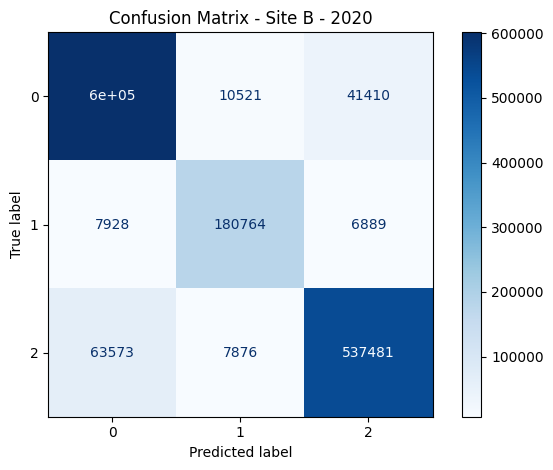


Saved labeled data for variation_ratio to true_BCNN_selected_data/true_BCNN_data_variation_ratio.npz

 Running strategy: BVSB 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 388743
Length of Labeled Pool: 4000
Length of Unlabeled Pool: 384743
Class weights: tensor([0.7432, 1.2500, 0.8061], device='cuda:0')

-> Training on 4000 initially labeled samples 


Training Epoch 1: 100%|██████████| 63/63 [00:01<00:00, 42.93it/s]


Loss: 0.3144 + 1e-08 * 2859886.5
Loss: 0.3144 + 0.028598865494132042
Epoch [1/20] Train Loss: 1.0212, Train Acc: 0.6767


Training Epoch 2: 100%|██████████| 63/63 [00:01<00:00, 42.98it/s]


Loss: 0.2912 + 1e-08 * 2851777.25
Loss: 0.2912 + 0.028517771512269974
Epoch [2/20] Train Loss: 0.5662, Train Acc: 0.7935


Training Epoch 3: 100%|██████████| 63/63 [00:01<00:00, 42.32it/s]


Loss: 0.5610 + 1e-08 * 2842144.0
Loss: 0.5610 + 0.028421439230442047
Epoch [3/20] Train Loss: 0.5031, Train Acc: 0.8145


Training Epoch 4: 100%|██████████| 63/63 [00:01<00:00, 42.77it/s]


Loss: 0.4889 + 1e-08 * 2830518.0
Loss: 0.4889 + 0.028305180370807648
Epoch [4/20] Train Loss: 0.4408, Train Acc: 0.8403


Training Epoch 5: 100%|██████████| 63/63 [00:01<00:00, 42.96it/s]


Loss: 0.4433 + 1e-08 * 2819454.0
Loss: 0.4433 + 0.02819453924894333
Epoch [5/20] Train Loss: 0.4363, Train Acc: 0.8330


Training Epoch 6: 100%|██████████| 63/63 [00:01<00:00, 42.96it/s]


Loss: 0.7503 + 1e-08 * 2807963.5
Loss: 0.7503 + 0.02807963453233242
Epoch [6/20] Train Loss: 0.4122, Train Acc: 0.8488


Training Epoch 7: 100%|██████████| 63/63 [00:01<00:00, 42.93it/s]


Loss: 0.3031 + 1e-08 * 2796669.25
Loss: 0.3031 + 0.0279666930437088
Epoch [7/20] Train Loss: 0.3937, Train Acc: 0.8528


Training Epoch 8: 100%|██████████| 63/63 [00:01<00:00, 43.00it/s]


Loss: 0.2776 + 1e-08 * 2785651.25
Loss: 0.2776 + 0.027856511995196342
Epoch [8/20] Train Loss: 0.3890, Train Acc: 0.8528


Training Epoch 9: 100%|██████████| 63/63 [00:01<00:00, 42.67it/s]


Loss: 0.2708 + 1e-08 * 2773663.25
Loss: 0.2708 + 0.027736632153391838
Epoch [9/20] Train Loss: 0.3746, Train Acc: 0.8610


Training Epoch 10: 100%|██████████| 63/63 [00:01<00:00, 42.80it/s]


Loss: 0.4636 + 1e-08 * 2762104.75
Loss: 0.4636 + 0.02762104757130146
Epoch [10/20] Train Loss: 0.3710, Train Acc: 0.8650


Training Epoch 11: 100%|██████████| 63/63 [00:01<00:00, 42.83it/s]


Loss: 0.3199 + 1e-08 * 2750310.25
Loss: 0.3199 + 0.027503103017807007
Epoch [11/20] Train Loss: 0.3658, Train Acc: 0.8635


Training Epoch 12: 100%|██████████| 63/63 [00:01<00:00, 43.03it/s]


Loss: 0.3184 + 1e-08 * 2739333.75
Loss: 0.3184 + 0.027393337339162827
Epoch [12/20] Train Loss: 0.3510, Train Acc: 0.8662


Training Epoch 13: 100%|██████████| 63/63 [00:01<00:00, 42.47it/s]


Loss: 0.3976 + 1e-08 * 2727536.0
Loss: 0.3976 + 0.027275359258055687
Epoch [13/20] Train Loss: 0.3569, Train Acc: 0.8692


Training Epoch 14: 100%|██████████| 63/63 [00:01<00:00, 42.82it/s]


Loss: 0.2868 + 1e-08 * 2717795.75
Loss: 0.2868 + 0.027177957817912102
Epoch [14/20] Train Loss: 0.3516, Train Acc: 0.8698


Training Epoch 15: 100%|██████████| 63/63 [00:01<00:00, 42.81it/s]


Loss: 0.4494 + 1e-08 * 2706497.5
Loss: 0.4494 + 0.0270649753510952
Epoch [15/20] Train Loss: 0.3397, Train Acc: 0.8680


Training Epoch 16: 100%|██████████| 63/63 [00:01<00:00, 42.45it/s]


Loss: 0.6066 + 1e-08 * 2696532.5
Loss: 0.6066 + 0.026965325698256493
Epoch [16/20] Train Loss: 0.3481, Train Acc: 0.8718


Training Epoch 17: 100%|██████████| 63/63 [00:01<00:00, 42.56it/s]


Loss: 0.1340 + 1e-08 * 2687480.5
Loss: 0.1340 + 0.026874804869294167
Epoch [17/20] Train Loss: 0.3339, Train Acc: 0.8788


Training Epoch 18: 100%|██████████| 63/63 [00:01<00:00, 42.80it/s]


Loss: 0.1570 + 1e-08 * 2676313.0
Loss: 0.1570 + 0.026763129979372025
Epoch [18/20] Train Loss: 0.3221, Train Acc: 0.8788


Training Epoch 19: 100%|██████████| 63/63 [00:01<00:00, 42.84it/s]


Loss: 0.3295 + 1e-08 * 2666211.25
Loss: 0.3295 + 0.026662113144993782
Epoch [19/20] Train Loss: 0.3090, Train Acc: 0.8848


Training Epoch 20: 100%|██████████| 63/63 [00:01<00:00, 43.04it/s]


Loss: 0.1380 + 1e-08 * 2657263.25
Loss: 0.1380 + 0.026572631672024727
Epoch [20/20] Train Loss: 0.3164, Train Acc: 0.8842


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.38it/s]


Per-class F1 scores: [0.88779791 0.90720019 0.88510767]
Validation Accuracy: 88.92%
Validation Loss: 0.3127
Average F1 Score: 0.8934
Kappa: 0.8165

--- Round 1 [bvsb] ---


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:29<00:00, 38.92s/it]


Length of Labeled Pool: 5000
Length of Unlabeled Pool: 383743


Training Epoch 1: 100%|██████████| 79/79 [00:01<00:00, 42.82it/s]


Loss: 0.1287 + 1e-08 * 2639421.0
Loss: 0.1287 + 0.026394210755825043
Epoch [1/20] Train Loss: 0.4512, Train Acc: 0.8104


Training Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 42.35it/s]


Loss: 1.2678 + 1e-08 * 2627558.5
Loss: 1.2678 + 0.02627558447420597
Epoch [2/20] Train Loss: 0.4263, Train Acc: 0.8180


Training Epoch 3: 100%|██████████| 79/79 [00:01<00:00, 42.55it/s]


Loss: 0.2897 + 1e-08 * 2618469.0
Loss: 0.2897 + 0.02618468925356865
Epoch [3/20] Train Loss: 0.4242, Train Acc: 0.8224


Training Epoch 4: 100%|██████████| 79/79 [00:01<00:00, 42.50it/s]


Loss: 0.8504 + 1e-08 * 2606473.25
Loss: 0.8504 + 0.026064733043313026
Epoch [4/20] Train Loss: 0.4101, Train Acc: 0.8316


Training Epoch 5: 100%|██████████| 79/79 [00:01<00:00, 42.27it/s]


Loss: 1.2000 + 1e-08 * 2598969.0
Loss: 1.2000 + 0.02598968893289566
Epoch [5/20] Train Loss: 0.4125, Train Acc: 0.8272


Training Epoch 6: 100%|██████████| 79/79 [00:01<00:00, 42.87it/s]


Loss: 0.2383 + 1e-08 * 2588392.25
Loss: 0.2383 + 0.02588392235338688
Epoch [6/20] Train Loss: 0.4006, Train Acc: 0.8370


Training Epoch 7: 100%|██████████| 79/79 [00:01<00:00, 42.63it/s]


Loss: 0.7476 + 1e-08 * 2575883.25
Loss: 0.7476 + 0.025758832693099976
Epoch [7/20] Train Loss: 0.4022, Train Acc: 0.8304


Training Epoch 8: 100%|██████████| 79/79 [00:01<00:00, 42.43it/s]


Loss: 0.8498 + 1e-08 * 2568330.75
Loss: 0.8498 + 0.025683308020234108
Epoch [8/20] Train Loss: 0.4048, Train Acc: 0.8342


Training Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 42.42it/s]


Loss: 0.5206 + 1e-08 * 2562810.75
Loss: 0.5206 + 0.0256281066685915
Epoch [9/20] Train Loss: 0.4063, Train Acc: 0.8334


Training Epoch 10: 100%|██████████| 79/79 [00:01<00:00, 42.66it/s]


Loss: 0.6302 + 1e-08 * 2553482.0
Loss: 0.6302 + 0.025534819811582565
Epoch [10/20] Train Loss: 0.4000, Train Acc: 0.8404


Training Epoch 11: 100%|██████████| 79/79 [00:01<00:00, 41.09it/s]


Loss: 0.2509 + 1e-08 * 2543826.0
Loss: 0.2509 + 0.025438260287046432
Epoch [11/20] Train Loss: 0.3740, Train Acc: 0.8474


Training Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 41.39it/s]


Loss: 0.4408 + 1e-08 * 2535320.5
Loss: 0.4408 + 0.02535320445895195
Epoch [12/20] Train Loss: 0.3798, Train Acc: 0.8442


Training Epoch 13: 100%|██████████| 79/79 [00:01<00:00, 42.40it/s]


Loss: 0.7608 + 1e-08 * 2527703.0
Loss: 0.7608 + 0.025277029722929
Epoch [13/20] Train Loss: 0.3724, Train Acc: 0.8482


Training Epoch 14: 100%|██████████| 79/79 [00:01<00:00, 42.85it/s]


Loss: 0.7311 + 1e-08 * 2519606.5
Loss: 0.7311 + 0.02519606426358223
Epoch [14/20] Train Loss: 0.3772, Train Acc: 0.8540


Training Epoch 15: 100%|██████████| 79/79 [00:01<00:00, 41.94it/s]


Loss: 0.2710 + 1e-08 * 2512979.5
Loss: 0.2710 + 0.02512979507446289
Epoch [15/20] Train Loss: 0.3680, Train Acc: 0.8506


Training Epoch 16: 100%|██████████| 79/79 [00:01<00:00, 42.87it/s]


Loss: 0.3373 + 1e-08 * 2503070.25
Loss: 0.3373 + 0.025030702352523804
Epoch [16/20] Train Loss: 0.3797, Train Acc: 0.8462


Training Epoch 17: 100%|██████████| 79/79 [00:01<00:00, 42.98it/s]


Loss: 0.2407 + 1e-08 * 2493429.5
Loss: 0.2407 + 0.024934295564889908
Epoch [17/20] Train Loss: 0.3596, Train Acc: 0.8530


Training Epoch 18: 100%|██████████| 79/79 [00:01<00:00, 42.65it/s]


Loss: 0.6429 + 1e-08 * 2485014.0
Loss: 0.6429 + 0.024850139394402504
Epoch [18/20] Train Loss: 0.3522, Train Acc: 0.8578


Training Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 42.81it/s]


Loss: 0.3843 + 1e-08 * 2475755.0
Loss: 0.3843 + 0.024757549166679382
Epoch [19/20] Train Loss: 0.3494, Train Acc: 0.8586


Training Epoch 20: 100%|██████████| 79/79 [00:01<00:00, 42.95it/s]


Loss: 0.8465 + 1e-08 * 2467989.0
Loss: 0.8465 + 0.024679889902472496
Epoch [20/20] Train Loss: 0.3485, Train Acc: 0.8592


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 136.76it/s]


Per-class F1 scores: [0.89940681 0.91414771 0.89575702]
Validation Accuracy: 89.98%
Validation Loss: 0.2952
Average F1 Score: 0.9031
Kappa: 0.8345

--- Round 2 [bvsb] ---


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:28<00:00, 38.86s/it]


Length of Labeled Pool: 6000
Length of Unlabeled Pool: 382743


Training Epoch 1: 100%|██████████| 94/94 [00:02<00:00, 42.84it/s]


Loss: 0.6328 + 1e-08 * 2453380.5
Loss: 0.6328 + 0.02453380450606346
Epoch [1/20] Train Loss: 0.4521, Train Acc: 0.7962


Training Epoch 2: 100%|██████████| 94/94 [00:02<00:00, 42.93it/s]


Loss: 0.4849 + 1e-08 * 2444206.5
Loss: 0.4849 + 0.024442065507173538
Epoch [2/20] Train Loss: 0.4533, Train Acc: 0.7997


Training Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 42.53it/s]


Loss: 0.3197 + 1e-08 * 2434636.75
Loss: 0.3197 + 0.02434636652469635
Epoch [3/20] Train Loss: 0.4447, Train Acc: 0.8100


Training Epoch 4: 100%|██████████| 94/94 [00:02<00:00, 42.79it/s]


Loss: 0.3441 + 1e-08 * 2425000.0
Loss: 0.3441 + 0.024250000715255737
Epoch [4/20] Train Loss: 0.4375, Train Acc: 0.8040


Training Epoch 5: 100%|██████████| 94/94 [00:02<00:00, 42.58it/s]


Loss: 0.3484 + 1e-08 * 2416835.75
Loss: 0.3484 + 0.024168357253074646
Epoch [5/20] Train Loss: 0.4317, Train Acc: 0.8107


Training Epoch 6: 100%|██████████| 94/94 [00:02<00:00, 42.67it/s]


Loss: 0.2834 + 1e-08 * 2407266.5
Loss: 0.2834 + 0.024072665721178055
Epoch [6/20] Train Loss: 0.4350, Train Acc: 0.8072


Training Epoch 7: 100%|██████████| 94/94 [00:02<00:00, 42.84it/s]


Loss: 0.3055 + 1e-08 * 2398980.75
Loss: 0.3055 + 0.023989807814359665
Epoch [7/20] Train Loss: 0.4263, Train Acc: 0.8170


Training Epoch 8: 100%|██████████| 94/94 [00:02<00:00, 42.54it/s]


Loss: 0.3387 + 1e-08 * 2389885.25
Loss: 0.3387 + 0.023898852989077568
Epoch [8/20] Train Loss: 0.4165, Train Acc: 0.8210


Training Epoch 9: 100%|██████████| 94/94 [00:02<00:00, 42.61it/s]


Loss: 0.4880 + 1e-08 * 2381262.5
Loss: 0.4880 + 0.02381262555718422
Epoch [9/20] Train Loss: 0.4193, Train Acc: 0.8185


Training Epoch 10: 100%|██████████| 94/94 [00:02<00:00, 42.73it/s]


Loss: 0.4313 + 1e-08 * 2373136.25
Loss: 0.4313 + 0.02373136207461357
Epoch [10/20] Train Loss: 0.4139, Train Acc: 0.8260


Training Epoch 11: 100%|██████████| 94/94 [00:02<00:00, 42.70it/s]


Loss: 0.3163 + 1e-08 * 2365202.5
Loss: 0.3163 + 0.023652024567127228
Epoch [11/20] Train Loss: 0.4110, Train Acc: 0.8233


Training Epoch 12: 100%|██████████| 94/94 [00:02<00:00, 42.46it/s]


Loss: 0.5510 + 1e-08 * 2357581.0
Loss: 0.5510 + 0.023575810715556145
Epoch [12/20] Train Loss: 0.4076, Train Acc: 0.8247


Training Epoch 13: 100%|██████████| 94/94 [00:02<00:00, 42.79it/s]


Loss: 0.3832 + 1e-08 * 2349740.0
Loss: 0.3832 + 0.02349739894270897
Epoch [13/20] Train Loss: 0.4026, Train Acc: 0.8272


Training Epoch 14: 100%|██████████| 94/94 [00:02<00:00, 42.83it/s]


Loss: 0.4603 + 1e-08 * 2342301.5
Loss: 0.4603 + 0.02342301420867443
Epoch [14/20] Train Loss: 0.4064, Train Acc: 0.8280


Training Epoch 15: 100%|██████████| 94/94 [00:02<00:00, 42.84it/s]


Loss: 0.3861 + 1e-08 * 2336365.0
Loss: 0.3861 + 0.02336364984512329
Epoch [15/20] Train Loss: 0.3993, Train Acc: 0.8297


Training Epoch 16: 100%|██████████| 94/94 [00:02<00:00, 43.00it/s]


Loss: 0.3957 + 1e-08 * 2329777.0
Loss: 0.3957 + 0.02329776994884014
Epoch [16/20] Train Loss: 0.3914, Train Acc: 0.8368


Training Epoch 17: 100%|██████████| 94/94 [00:02<00:00, 42.33it/s]


Loss: 0.3704 + 1e-08 * 2323550.25
Loss: 0.3704 + 0.02323550172150135
Epoch [17/20] Train Loss: 0.3838, Train Acc: 0.8377


Training Epoch 18: 100%|██████████| 94/94 [00:02<00:00, 42.84it/s]


Loss: 0.4068 + 1e-08 * 2317533.75
Loss: 0.4068 + 0.02317533828318119
Epoch [18/20] Train Loss: 0.3922, Train Acc: 0.8295


Training Epoch 19: 100%|██████████| 94/94 [00:02<00:00, 42.86it/s]


Loss: 0.2962 + 1e-08 * 2311288.5
Loss: 0.2962 + 0.023112885653972626
Epoch [19/20] Train Loss: 0.3833, Train Acc: 0.8377


Training Epoch 20: 100%|██████████| 94/94 [00:02<00:00, 42.84it/s]


Loss: 0.4395 + 1e-08 * 2304262.25
Loss: 0.4395 + 0.023042622953653336
Epoch [20/20] Train Loss: 0.3811, Train Acc: 0.8377


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.97it/s]


Per-class F1 scores: [0.89952762 0.91286853 0.89284493]
Validation Accuracy: 89.86%
Validation Loss: 0.3009
Average F1 Score: 0.9017
Kappa: 0.8324

--- Round 3 [bvsb] ---


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:26<00:00, 38.69s/it]


Length of Labeled Pool: 7000
Length of Unlabeled Pool: 381743


Training Epoch 1: 100%|██████████| 110/110 [00:02<00:00, 42.51it/s]


Loss: 0.6190 + 1e-08 * 2291367.5
Loss: 0.6190 + 0.022913675755262375
Epoch [1/20] Train Loss: 0.4639, Train Acc: 0.8001


Training Epoch 2: 100%|██████████| 110/110 [00:02<00:00, 42.66it/s]


Loss: 0.2886 + 1e-08 * 2282720.5
Loss: 0.2886 + 0.022827204316854477
Epoch [2/20] Train Loss: 0.4612, Train Acc: 0.7886


Training Epoch 3: 100%|██████████| 110/110 [00:02<00:00, 42.45it/s]


Loss: 0.5316 + 1e-08 * 2275786.25
Loss: 0.5316 + 0.022757861763238907
Epoch [3/20] Train Loss: 0.4546, Train Acc: 0.8011


Training Epoch 4: 100%|██████████| 110/110 [00:02<00:00, 42.53it/s]


Loss: 0.2972 + 1e-08 * 2267166.0
Loss: 0.2972 + 0.022671660408377647
Epoch [4/20] Train Loss: 0.4408, Train Acc: 0.8087


Training Epoch 5: 100%|██████████| 110/110 [00:02<00:00, 42.43it/s]


Loss: 0.6129 + 1e-08 * 2259675.25
Loss: 0.6129 + 0.022596752271056175
Epoch [5/20] Train Loss: 0.4380, Train Acc: 0.8084


Training Epoch 6: 100%|██████████| 110/110 [00:02<00:00, 42.38it/s]


Loss: 0.4325 + 1e-08 * 2253459.25
Loss: 0.4325 + 0.02253459207713604
Epoch [6/20] Train Loss: 0.4467, Train Acc: 0.8014


Training Epoch 7: 100%|██████████| 110/110 [00:02<00:00, 42.51it/s]


Loss: 0.5643 + 1e-08 * 2247478.75
Loss: 0.5643 + 0.02247478812932968
Epoch [7/20] Train Loss: 0.4377, Train Acc: 0.8060


Training Epoch 8: 100%|██████████| 110/110 [00:02<00:00, 42.27it/s]


Loss: 0.3391 + 1e-08 * 2241196.0
Loss: 0.3391 + 0.022411959245800972
Epoch [8/20] Train Loss: 0.4225, Train Acc: 0.8126


Training Epoch 9: 100%|██████████| 110/110 [00:02<00:00, 42.33it/s]


Loss: 0.4476 + 1e-08 * 2235977.5
Loss: 0.4476 + 0.022359775379300117
Epoch [9/20] Train Loss: 0.4311, Train Acc: 0.8157


Training Epoch 10: 100%|██████████| 110/110 [00:02<00:00, 42.16it/s]


Loss: 0.3995 + 1e-08 * 2229799.75
Loss: 0.3995 + 0.022297997027635574
Epoch [10/20] Train Loss: 0.4263, Train Acc: 0.8137


Training Epoch 11: 100%|██████████| 110/110 [00:02<00:00, 42.76it/s]


Loss: 0.2751 + 1e-08 * 2225922.5
Loss: 0.2751 + 0.022259224206209183
Epoch [11/20] Train Loss: 0.4277, Train Acc: 0.8151


Training Epoch 12: 100%|██████████| 110/110 [00:02<00:00, 42.58it/s]


Loss: 0.6533 + 1e-08 * 2220759.75
Loss: 0.6533 + 0.02220759727060795
Epoch [12/20] Train Loss: 0.4166, Train Acc: 0.8157


Training Epoch 13: 100%|██████████| 110/110 [00:02<00:00, 42.74it/s]


Loss: 0.2646 + 1e-08 * 2214382.0
Loss: 0.2646 + 0.02214382030069828
Epoch [13/20] Train Loss: 0.4262, Train Acc: 0.8133


Training Epoch 14: 100%|██████████| 110/110 [00:02<00:00, 42.53it/s]


Loss: 0.4245 + 1e-08 * 2208475.75
Loss: 0.4245 + 0.022084757685661316
Epoch [14/20] Train Loss: 0.4136, Train Acc: 0.8176


Training Epoch 15: 100%|██████████| 110/110 [00:02<00:00, 42.70it/s]


Loss: 0.5302 + 1e-08 * 2203907.75
Loss: 0.5302 + 0.022039078176021576
Epoch [15/20] Train Loss: 0.4120, Train Acc: 0.8191


Training Epoch 16: 100%|██████████| 110/110 [00:02<00:00, 42.72it/s]


Loss: 0.2760 + 1e-08 * 2199065.75
Loss: 0.2760 + 0.021990656852722168
Epoch [16/20] Train Loss: 0.4012, Train Acc: 0.8284


Training Epoch 17: 100%|██████████| 110/110 [00:02<00:00, 42.69it/s]


Loss: 0.4159 + 1e-08 * 2193364.5
Loss: 0.4159 + 0.021933645009994507
Epoch [17/20] Train Loss: 0.4027, Train Acc: 0.8267


Training Epoch 18: 100%|██████████| 110/110 [00:02<00:00, 42.73it/s]


Loss: 0.2714 + 1e-08 * 2189535.0
Loss: 0.2714 + 0.02189534902572632
Epoch [18/20] Train Loss: 0.4019, Train Acc: 0.8271


Training Epoch 19: 100%|██████████| 110/110 [00:02<00:00, 42.86it/s]


Loss: 0.3617 + 1e-08 * 2187196.75
Loss: 0.3617 + 0.021871967241168022
Epoch [19/20] Train Loss: 0.4086, Train Acc: 0.8217


Training Epoch 20: 100%|██████████| 110/110 [00:02<00:00, 42.68it/s]


Loss: 0.2435 + 1e-08 * 2183014.5
Loss: 0.2435 + 0.02183014526963234
Epoch [20/20] Train Loss: 0.3931, Train Acc: 0.8290


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.25it/s]


Per-class F1 scores: [0.90446331 0.91440678 0.89889515]
Validation Accuracy: 90.35%
Validation Loss: 0.2964
Average F1 Score: 0.9059
Kappa: 0.8407

--- Round 4 [bvsb] ---


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:26<00:00, 38.70s/it]


Length of Labeled Pool: 8000
Length of Unlabeled Pool: 380743


Training Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 42.77it/s]


Loss: 0.3393 + 1e-08 * 2172120.25
Loss: 0.3393 + 0.02172120288014412
Epoch [1/20] Train Loss: 0.4658, Train Acc: 0.7920


Training Epoch 2: 100%|██████████| 125/125 [00:02<00:00, 42.79it/s]


Loss: 0.4200 + 1e-08 * 2165559.75
Loss: 0.4200 + 0.021655596792697906
Epoch [2/20] Train Loss: 0.4614, Train Acc: 0.7941


Training Epoch 3: 100%|██████████| 125/125 [00:02<00:00, 42.45it/s]


Loss: 0.3492 + 1e-08 * 2159028.0
Loss: 0.3492 + 0.021590279415249825
Epoch [3/20] Train Loss: 0.4556, Train Acc: 0.7949


Training Epoch 4: 100%|██████████| 125/125 [00:02<00:00, 42.67it/s]


Loss: 0.4851 + 1e-08 * 2152872.0
Loss: 0.4851 + 0.02152871899306774
Epoch [4/20] Train Loss: 0.4501, Train Acc: 0.7997


Training Epoch 5: 100%|██████████| 125/125 [00:02<00:00, 42.62it/s]


Loss: 0.4411 + 1e-08 * 2147074.0
Loss: 0.4411 + 0.02147074043750763
Epoch [5/20] Train Loss: 0.4502, Train Acc: 0.7969


Training Epoch 6: 100%|██████████| 125/125 [00:02<00:00, 42.71it/s]


Loss: 0.4384 + 1e-08 * 2142177.0
Loss: 0.4384 + 0.0214217696338892
Epoch [6/20] Train Loss: 0.4510, Train Acc: 0.8005


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:26<00:00, 38.68s/it]


Length of Labeled Pool: 9000
Length of Unlabeled Pool: 379743


Training Epoch 1: 100%|██████████| 141/141 [00:03<00:00, 42.61it/s]


Loss: 0.5043 + 1e-08 * 2078438.25
Loss: 0.5043 + 0.02078438177704811
Epoch [1/20] Train Loss: 0.4902, Train Acc: 0.7828


Training Epoch 2: 100%|██████████| 141/141 [00:03<00:00, 42.39it/s]


Loss: 0.5619 + 1e-08 * 2071454.625
Loss: 0.5619 + 0.020714545622467995
Epoch [2/20] Train Loss: 0.4858, Train Acc: 0.7868


Training Epoch 3: 100%|██████████| 141/141 [00:03<00:00, 42.13it/s]


Loss: 0.5238 + 1e-08 * 2067653.0
Loss: 0.5238 + 0.02067652903497219
Epoch [3/20] Train Loss: 0.4826, Train Acc: 0.7879


Training Epoch 4: 100%|██████████| 141/141 [00:03<00:00, 41.47it/s]


Loss: 0.5030 + 1e-08 * 2062989.125
Loss: 0.5030 + 0.020629890263080597
Epoch [4/20] Train Loss: 0.4715, Train Acc: 0.7947


Training Epoch 5: 100%|██████████| 141/141 [00:03<00:00, 42.29it/s]


Loss: 0.5652 + 1e-08 * 2059066.875
Loss: 0.5652 + 0.02059066854417324
Epoch [5/20] Train Loss: 0.4611, Train Acc: 0.7971


Training Epoch 6: 100%|██████████| 141/141 [00:03<00:00, 42.48it/s]


Loss: 0.4720 + 1e-08 * 2055453.875
Loss: 0.4720 + 0.020554538816213608
Epoch [6/20] Train Loss: 0.4643, Train Acc: 0.7932


Training Epoch 7: 100%|██████████| 141/141 [00:03<00:00, 42.59it/s]


Loss: 0.3991 + 1e-08 * 2051415.375
Loss: 0.3991 + 0.020514152944087982
Epoch [7/20] Train Loss: 0.4605, Train Acc: 0.7991


Training Epoch 8: 100%|██████████| 141/141 [00:03<00:00, 42.35it/s]


Loss: 0.3983 + 1e-08 * 2048064.875
Loss: 0.3983 + 0.020480649545788765
Epoch [8/20] Train Loss: 0.4525, Train Acc: 0.8004


Training Epoch 9: 100%|██████████| 141/141 [00:03<00:00, 42.42it/s]


Loss: 0.5249 + 1e-08 * 2045663.25
Loss: 0.5249 + 0.02045663259923458
Epoch [9/20] Train Loss: 0.4588, Train Acc: 0.7991


Training Epoch 10: 100%|██████████| 141/141 [00:03<00:00, 42.76it/s]


Loss: 0.2960 + 1e-08 * 2042739.0
Loss: 0.2960 + 0.020427389070391655
Epoch [10/20] Train Loss: 0.4487, Train Acc: 0.8049


Training Epoch 11: 100%|██████████| 141/141 [00:03<00:00, 42.87it/s]


Loss: 0.6370 + 1e-08 * 2040353.625
Loss: 0.6370 + 0.020403536036610603
Epoch [11/20] Train Loss: 0.4579, Train Acc: 0.7972


Training Epoch 12: 100%|██████████| 141/141 [00:03<00:00, 42.37it/s]


Loss: 0.4338 + 1e-08 * 2035981.125
Loss: 0.4338 + 0.020359810441732407
Epoch [12/20] Train Loss: 0.4455, Train Acc: 0.8059


Training Epoch 13: 100%|██████████| 141/141 [00:03<00:00, 42.69it/s]


Loss: 0.5520 + 1e-08 * 2034724.875
Loss: 0.5520 + 0.020347248762845993
Epoch [13/20] Train Loss: 0.4447, Train Acc: 0.8042


Training Epoch 14: 100%|██████████| 141/141 [00:03<00:00, 42.65it/s]


Loss: 0.3989 + 1e-08 * 2032539.875
Loss: 0.3989 + 0.020325398072600365
Epoch [14/20] Train Loss: 0.4389, Train Acc: 0.8138


Training Epoch 15: 100%|██████████| 141/141 [00:03<00:00, 42.25it/s]


Loss: 0.4434 + 1e-08 * 2031067.75
Loss: 0.4434 + 0.020310677587985992
Epoch [15/20] Train Loss: 0.4373, Train Acc: 0.8082


Training Epoch 16: 100%|██████████| 141/141 [00:03<00:00, 42.68it/s]


Loss: 0.4537 + 1e-08 * 2027191.75
Loss: 0.4537 + 0.020271917805075645
Epoch [16/20] Train Loss: 0.4396, Train Acc: 0.8064


Training Epoch 17: 100%|██████████| 141/141 [00:03<00:00, 42.68it/s]


Loss: 0.4599 + 1e-08 * 2025216.125
Loss: 0.4599 + 0.020252160727977753
Epoch [17/20] Train Loss: 0.4393, Train Acc: 0.8108


Training Epoch 18: 100%|██████████| 141/141 [00:03<00:00, 42.57it/s]


Loss: 0.5035 + 1e-08 * 2022410.0
Loss: 0.5035 + 0.02022409997880459
Epoch [18/20] Train Loss: 0.4266, Train Acc: 0.8131


Training Epoch 19: 100%|██████████| 141/141 [00:03<00:00, 42.65it/s]


Loss: 0.6712 + 1e-08 * 2021432.25
Loss: 0.6712 + 0.020214322954416275
Epoch [19/20] Train Loss: 0.4350, Train Acc: 0.8113


Training Epoch 20: 100%|██████████| 141/141 [00:03<00:00, 42.76it/s]


Loss: 0.4334 + 1e-08 * 2018860.25
Loss: 0.4334 + 0.020188601687550545
Epoch [20/20] Train Loss: 0.4257, Train Acc: 0.8140


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.09it/s]


Per-class F1 scores: [0.90650388 0.91376993 0.90128335]
Validation Accuracy: 90.53%
Validation Loss: 0.2920
Average F1 Score: 0.9072
Kappa: 0.8438

--- Round 6 [bvsb] ---


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:23<00:00, 38.36s/it]


Length of Labeled Pool: 10000
Length of Unlabeled Pool: 378743


Training Epoch 1: 100%|██████████| 157/157 [00:03<00:00, 42.76it/s]


Loss: 0.6596 + 1e-08 * 2010757.625
Loss: 0.6596 + 0.020107576623558998
Epoch [1/20] Train Loss: 0.4964, Train Acc: 0.7781


Training Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 42.51it/s]


Loss: 1.1392 + 1e-08 * 2006464.875
Loss: 1.1392 + 0.020064648240804672
Epoch [2/20] Train Loss: 0.4811, Train Acc: 0.7830


Training Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 42.79it/s]


Loss: 0.7620 + 1e-08 * 2002526.875
Loss: 0.7620 + 0.02002526819705963
Epoch [3/20] Train Loss: 0.4773, Train Acc: 0.7852


Training Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 42.67it/s]


Loss: 0.3414 + 1e-08 * 1999879.125
Loss: 0.3414 + 0.019998790696263313
Epoch [4/20] Train Loss: 0.4714, Train Acc: 0.7938


Training Epoch 5: 100%|██████████| 157/157 [00:03<00:00, 42.81it/s]


Loss: 0.8030 + 1e-08 * 1997321.875
Loss: 0.8030 + 0.01997321844100952
Epoch [5/20] Train Loss: 0.4782, Train Acc: 0.7893


Training Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 42.62it/s]


Loss: 0.6871 + 1e-08 * 1994553.875
Loss: 0.6871 + 0.01994553953409195
Epoch [6/20] Train Loss: 0.4690, Train Acc: 0.7891


Training Epoch 7: 100%|██████████| 157/157 [00:03<00:00, 42.81it/s]


Loss: 0.3657 + 1e-08 * 1991963.5
Loss: 0.3657 + 0.019919635728001595
Epoch [7/20] Train Loss: 0.4647, Train Acc: 0.7958


Training Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 42.57it/s]


Loss: 0.6251 + 1e-08 * 1988758.125
Loss: 0.6251 + 0.01988758146762848
Epoch [8/20] Train Loss: 0.4601, Train Acc: 0.7967


Training Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 42.70it/s]


Loss: 0.4763 + 1e-08 * 1985666.5
Loss: 0.4763 + 0.019856665283441544
Epoch [9/20] Train Loss: 0.4566, Train Acc: 0.7977


Training Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 42.71it/s]


Loss: 0.7217 + 1e-08 * 1983465.625
Loss: 0.7217 + 0.01983465626835823
Epoch [10/20] Train Loss: 0.4594, Train Acc: 0.7987


Training Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 43.03it/s]


Loss: 0.5013 + 1e-08 * 1981688.5
Loss: 0.5013 + 0.019816884770989418
Epoch [11/20] Train Loss: 0.4511, Train Acc: 0.8035


Training Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 42.91it/s]


Loss: 0.7309 + 1e-08 * 1979185.125
Loss: 0.7309 + 0.019791850820183754
Epoch [12/20] Train Loss: 0.4603, Train Acc: 0.7933


Training Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 42.76it/s]


Loss: 0.4254 + 1e-08 * 1977562.625
Loss: 0.4254 + 0.019775625318288803
Epoch [13/20] Train Loss: 0.4579, Train Acc: 0.7949


Training Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 42.84it/s]


Loss: 0.6666 + 1e-08 * 1975393.625
Loss: 0.6666 + 0.019753936678171158
Epoch [14/20] Train Loss: 0.4572, Train Acc: 0.7974


Training Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 42.87it/s]


Loss: 0.1616 + 1e-08 * 1973316.5
Loss: 0.1616 + 0.019733164459466934
Epoch [15/20] Train Loss: 0.4527, Train Acc: 0.7956


Training Epoch 16: 100%|██████████| 157/157 [00:03<00:00, 42.64it/s]


Loss: 0.5759 + 1e-08 * 1972227.875
Loss: 0.5759 + 0.01972227916121483
Epoch [16/20] Train Loss: 0.4422, Train Acc: 0.8059


Training Epoch 17: 100%|██████████| 157/157 [00:03<00:00, 42.48it/s]


Loss: 0.8692 + 1e-08 * 1970594.25
Loss: 0.8692 + 0.019705941900610924
Epoch [17/20] Train Loss: 0.4500, Train Acc: 0.8033


Training Epoch 18: 100%|██████████| 157/157 [00:03<00:00, 41.87it/s]


Loss: 0.6208 + 1e-08 * 1970806.0
Loss: 0.6208 + 0.0197080597281456
Epoch [18/20] Train Loss: 0.4412, Train Acc: 0.8010


Training Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 42.38it/s]


Loss: 0.7925 + 1e-08 * 1970782.875
Loss: 0.7925 + 0.019707828760147095
Epoch [19/20] Train Loss: 0.4392, Train Acc: 0.8053


Training Epoch 20: 100%|██████████| 157/157 [00:03<00:00, 42.28it/s]


Loss: 0.2709 + 1e-08 * 1969732.5
Loss: 0.2709 + 0.01969732530415058
Epoch [20/20] Train Loss: 0.4427, Train Acc: 0.8075


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.00it/s]


Per-class F1 scores: [0.90314859 0.91713602 0.9003605 ]
Validation Accuracy: 90.38%
Validation Loss: 0.3025
Average F1 Score: 0.9069
Kappa: 0.8414

--- Round 7 [bvsb] ---


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:23<00:00, 38.34s/it]


Length of Labeled Pool: 11000
Length of Unlabeled Pool: 377743


Training Epoch 1: 100%|██████████| 172/172 [00:04<00:00, 42.46it/s]


Loss: 0.4109 + 1e-08 * 1963810.125
Loss: 0.4109 + 0.019638100638985634
Epoch [1/20] Train Loss: 0.4988, Train Acc: 0.7787


Training Epoch 2: 100%|██████████| 172/172 [00:04<00:00, 42.44it/s]


Loss: 0.6424 + 1e-08 * 1960271.375
Loss: 0.6424 + 0.019602714106440544
Epoch [2/20] Train Loss: 0.4918, Train Acc: 0.7865


Training Epoch 3: 100%|██████████| 172/172 [00:04<00:00, 42.57it/s]


Loss: 0.4366 + 1e-08 * 1957355.75
Loss: 0.4366 + 0.019573558121919632
Epoch [3/20] Train Loss: 0.4809, Train Acc: 0.7870


Training Epoch 4: 100%|██████████| 172/172 [00:04<00:00, 42.60it/s]


Loss: 0.4122 + 1e-08 * 1954843.875
Loss: 0.4122 + 0.019548438489437103
Epoch [4/20] Train Loss: 0.4850, Train Acc: 0.7881


Training Epoch 5: 100%|██████████| 172/172 [00:04<00:00, 42.37it/s]


Loss: 0.5177 + 1e-08 * 1953017.75
Loss: 0.5177 + 0.019530177116394043
Epoch [5/20] Train Loss: 0.4727, Train Acc: 0.7872


Training Epoch 6: 100%|██████████| 172/172 [00:04<00:00, 42.73it/s]


Loss: 0.5339 + 1e-08 * 1951280.625
Loss: 0.5339 + 0.019512806087732315
Epoch [6/20] Train Loss: 0.4742, Train Acc: 0.7917


Training Epoch 7: 100%|██████████| 172/172 [00:04<00:00, 42.41it/s]


Loss: 0.3850 + 1e-08 * 1949908.875
Loss: 0.3850 + 0.01949908770620823
Epoch [7/20] Train Loss: 0.4706, Train Acc: 0.7907


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:21<00:00, 38.17s/it]


Length of Labeled Pool: 12000
Length of Unlabeled Pool: 376743


Training Epoch 1: 100%|██████████| 188/188 [00:04<00:00, 42.66it/s]


Loss: 0.4359 + 1e-08 * 1936723.5
Loss: 0.4359 + 0.019367234781384468
Epoch [1/20] Train Loss: 0.4959, Train Acc: 0.7810


Training Epoch 2: 100%|██████████| 188/188 [00:04<00:00, 42.70it/s]


Loss: 0.4517 + 1e-08 * 1934409.5
Loss: 0.4517 + 0.019344095140695572
Epoch [2/20] Train Loss: 0.4882, Train Acc: 0.7823


Training Epoch 3: 100%|██████████| 188/188 [00:04<00:00, 42.69it/s]


Loss: 0.5248 + 1e-08 * 1932359.75
Loss: 0.5248 + 0.019323596730828285
Epoch [3/20] Train Loss: 0.4857, Train Acc: 0.7836


Training Epoch 4: 100%|██████████| 188/188 [00:04<00:00, 42.59it/s]


Loss: 0.4265 + 1e-08 * 1931402.125
Loss: 0.4265 + 0.01931402087211609
Epoch [4/20] Train Loss: 0.4850, Train Acc: 0.7892


Training Epoch 5: 100%|██████████| 188/188 [00:04<00:00, 42.76it/s]


Loss: 0.5162 + 1e-08 * 1930118.0
Loss: 0.5162 + 0.01930117979645729
Epoch [5/20] Train Loss: 0.4840, Train Acc: 0.7837


Training Epoch 6: 100%|██████████| 188/188 [00:04<00:00, 42.52it/s]


Loss: 0.3254 + 1e-08 * 1929688.125
Loss: 0.3254 + 0.019296880811452866
Epoch [6/20] Train Loss: 0.4818, Train Acc: 0.7886


Training Epoch 7: 100%|██████████| 188/188 [00:04<00:00, 42.59it/s]


Loss: 0.5509 + 1e-08 * 1928330.125
Loss: 0.5509 + 0.019283300265669823
Epoch [7/20] Train Loss: 0.4768, Train Acc: 0.7866


Training Epoch 8: 100%|██████████| 188/188 [00:04<00:00, 42.53it/s]


Loss: 0.3366 + 1e-08 * 1928072.875
Loss: 0.3366 + 0.019280727952718735
Epoch [8/20] Train Loss: 0.4777, Train Acc: 0.7899


Training Epoch 9: 100%|██████████| 188/188 [00:04<00:00, 42.65it/s]


Loss: 0.4927 + 1e-08 * 1928083.875
Loss: 0.4927 + 0.01928083784878254
Epoch [9/20] Train Loss: 0.4816, Train Acc: 0.7855


Training Epoch 10: 100%|██████████| 188/188 [00:04<00:00, 42.55it/s]


Loss: 0.2312 + 1e-08 * 1926933.125
Loss: 0.2312 + 0.01926933042705059
Epoch [10/20] Train Loss: 0.4743, Train Acc: 0.7880


Training Epoch 11: 100%|██████████| 188/188 [00:04<00:00, 42.76it/s]


Loss: 0.5283 + 1e-08 * 1926648.25
Loss: 0.5283 + 0.019266482442617416
Epoch [11/20] Train Loss: 0.4629, Train Acc: 0.7951


Training Epoch 12: 100%|██████████| 188/188 [00:04<00:00, 42.64it/s]


Loss: 0.3344 + 1e-08 * 1926904.25
Loss: 0.3344 + 0.01926904171705246
Epoch [12/20] Train Loss: 0.4655, Train Acc: 0.7970


Training Epoch 13: 100%|██████████| 188/188 [00:04<00:00, 42.56it/s]


Loss: 0.5436 + 1e-08 * 1926115.75
Loss: 0.5436 + 0.019261157140135765
Epoch [13/20] Train Loss: 0.4674, Train Acc: 0.7980


Training Epoch 14: 100%|██████████| 188/188 [00:04<00:00, 42.36it/s]


Loss: 0.6040 + 1e-08 * 1925899.0
Loss: 0.6040 + 0.01925898902118206
Epoch [14/20] Train Loss: 0.4736, Train Acc: 0.7902


Training Epoch 15: 100%|██████████| 188/188 [00:04<00:00, 42.47it/s]


Loss: 0.3954 + 1e-08 * 1926613.125
Loss: 0.3954 + 0.01926613040268421
Epoch [15/20] Train Loss: 0.4597, Train Acc: 0.7976


Training Epoch 16: 100%|██████████| 188/188 [00:04<00:00, 42.74it/s]


Loss: 0.5379 + 1e-08 * 1925861.875
Loss: 0.5379 + 0.019258618354797363
Epoch [16/20] Train Loss: 0.4602, Train Acc: 0.7964


Training Epoch 17: 100%|██████████| 188/188 [00:04<00:00, 42.56it/s]


Loss: 0.6208 + 1e-08 * 1925935.625
Loss: 0.6208 + 0.01925935596227646
Epoch [17/20] Train Loss: 0.4654, Train Acc: 0.7962


Training Epoch 18: 100%|██████████| 188/188 [00:04<00:00, 42.63it/s]


Loss: 0.4440 + 1e-08 * 1925464.375
Loss: 0.4440 + 0.019254643470048904
Epoch [18/20] Train Loss: 0.4611, Train Acc: 0.7985


Training Epoch 19: 100%|██████████| 188/188 [00:04<00:00, 42.75it/s]


Loss: 0.4461 + 1e-08 * 1924892.875
Loss: 0.4461 + 0.019248928874731064
Epoch [19/20] Train Loss: 0.4647, Train Acc: 0.7924


Training Epoch 20: 100%|██████████| 188/188 [00:04<00:00, 42.51it/s]


Loss: 0.3550 + 1e-08 * 1924820.125
Loss: 0.3550 + 0.019248200580477715
Epoch [20/20] Train Loss: 0.4562, Train Acc: 0.7988


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 137.64it/s]


Per-class F1 scores: [0.90420459 0.91739433 0.89901514]
Validation Accuracy: 90.38%
Validation Loss: 0.3005
Average F1 Score: 0.9069
Kappa: 0.8412

--- Round 9 [bvsb] ---


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:20<00:00, 38.04s/it]


Length of Labeled Pool: 13000
Length of Unlabeled Pool: 375743


Training Epoch 1: 100%|██████████| 204/204 [00:04<00:00, 42.53it/s]


Loss: 1.0094 + 1e-08 * 1920754.5
Loss: 1.0094 + 0.01920754462480545
Epoch [1/20] Train Loss: 0.5051, Train Acc: 0.7719


Training Epoch 2: 100%|██████████| 204/204 [00:04<00:00, 42.76it/s]


Loss: 0.6991 + 1e-08 * 1918879.125
Loss: 0.6991 + 0.019188791513442993
Epoch [2/20] Train Loss: 0.4974, Train Acc: 0.7802


Training Epoch 3: 100%|██████████| 204/204 [00:04<00:00, 42.69it/s]


Loss: 0.3641 + 1e-08 * 1918226.375
Loss: 0.3641 + 0.01918226294219494
Epoch [3/20] Train Loss: 0.5063, Train Acc: 0.7777


Training Epoch 4: 100%|██████████| 204/204 [00:04<00:00, 42.81it/s]


Loss: 1.1694 + 1e-08 * 1916859.0
Loss: 1.1694 + 0.019168589264154434
Epoch [4/20] Train Loss: 0.4898, Train Acc: 0.7786


Training Epoch 5: 100%|██████████| 204/204 [00:04<00:00, 42.15it/s]


Loss: 1.0002 + 1e-08 * 1917416.875
Loss: 1.0002 + 0.01917416788637638
Epoch [5/20] Train Loss: 0.4929, Train Acc: 0.7817


Training Epoch 6: 100%|██████████| 204/204 [00:04<00:00, 42.27it/s]


Loss: 0.2233 + 1e-08 * 1917127.875
Loss: 0.2233 + 0.019171278923749924
Epoch [6/20] Train Loss: 0.4969, Train Acc: 0.7768


Training Epoch 7: 100%|██████████| 204/204 [00:04<00:00, 42.74it/s]


Loss: 0.5333 + 1e-08 * 1917426.5
Loss: 0.5333 + 0.01917426474392414
Epoch [7/20] Train Loss: 0.4819, Train Acc: 0.7910


Training Epoch 8: 100%|██████████| 204/204 [00:04<00:00, 42.68it/s]


Loss: 1.3956 + 1e-08 * 1918093.5
Loss: 1.3956 + 0.019180934876203537
Epoch [8/20] Train Loss: 0.4913, Train Acc: 0.7815


Training Epoch 9: 100%|██████████| 204/204 [00:04<00:00, 42.66it/s]


Loss: 0.3759 + 1e-08 * 1918376.25
Loss: 0.3759 + 0.01918376237154007
Epoch [9/20] Train Loss: 0.4908, Train Acc: 0.7868


Training Epoch 10: 100%|██████████| 204/204 [00:04<00:00, 42.75it/s]


Loss: 0.5483 + 1e-08 * 1917176.0
Loss: 0.5483 + 0.019171759486198425
Epoch [10/20] Train Loss: 0.4878, Train Acc: 0.7831


Training Epoch 11: 100%|██████████| 204/204 [00:04<00:00, 42.84it/s]


Loss: 0.4253 + 1e-08 * 1917803.875
Loss: 0.4253 + 0.019178038462996483
Epoch [11/20] Train Loss: 0.4832, Train Acc: 0.7842


Training Epoch 12: 100%|██████████| 204/204 [00:04<00:00, 42.53it/s]


Loss: 0.1753 + 1e-08 * 1917615.125
Loss: 0.1753 + 0.019176151603460312
Epoch [12/20] Train Loss: 0.4785, Train Acc: 0.7874


Training Epoch 13: 100%|██████████| 204/204 [00:04<00:00, 42.72it/s]


Loss: 0.1968 + 1e-08 * 1918355.5
Loss: 0.1968 + 0.019183555617928505
Epoch [13/20] Train Loss: 0.4836, Train Acc: 0.7849


Training Epoch 14: 100%|██████████| 204/204 [00:04<00:00, 42.31it/s]


Loss: 0.3522 + 1e-08 * 1919485.0
Loss: 0.3522 + 0.01919485069811344
Epoch [14/20] Train Loss: 0.4791, Train Acc: 0.7870


Training Epoch 15: 100%|██████████| 204/204 [00:04<00:00, 42.82it/s]


Loss: 0.3450 + 1e-08 * 1920391.75
Loss: 0.3450 + 0.019203918054699898
Epoch [15/20] Train Loss: 0.4764, Train Acc: 0.7842


Training Epoch 16: 100%|██████████| 204/204 [00:04<00:00, 42.51it/s]


Loss: 1.0233 + 1e-08 * 1920541.5
Loss: 1.0233 + 0.01920541562139988
Epoch [16/20] Train Loss: 0.4731, Train Acc: 0.7904


Training Epoch 17: 100%|██████████| 204/204 [00:04<00:00, 42.68it/s]


Loss: 0.3350 + 1e-08 * 1921819.75
Loss: 0.3350 + 0.019218197092413902
Epoch [17/20] Train Loss: 0.4755, Train Acc: 0.7878


Training Epoch 18: 100%|██████████| 204/204 [00:04<00:00, 42.51it/s]


Loss: 0.4241 + 1e-08 * 1921849.875
Loss: 0.4241 + 0.019218498840928078
Epoch [18/20] Train Loss: 0.4685, Train Acc: 0.7978


Training Epoch 19: 100%|██████████| 204/204 [00:04<00:00, 42.73it/s]


Loss: 0.6819 + 1e-08 * 1923626.75
Loss: 0.6819 + 0.019236266613006592
Epoch [19/20] Train Loss: 0.4799, Train Acc: 0.7866


Training Epoch 20: 100%|██████████| 204/204 [00:04<00:00, 42.66it/s]


Loss: 0.4825 + 1e-08 * 1923998.25
Loss: 0.4825 + 0.019239982590079308
Epoch [20/20] Train Loss: 0.4679, Train Acc: 0.7986


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:10<00:00, 138.18it/s]


Per-class F1 scores: [0.90619265 0.91627689 0.90396072]
Validation Accuracy: 90.66%
Validation Loss: 0.2903
Average F1 Score: 0.9088
Kappa: 0.8457

--- Round 10 [bvsb] ---


MC Dropout Simulations (BvSB): 100%|██████████| 10/10 [06:20<00:00, 38.01s/it]


Length of Labeled Pool: 14000
Length of Unlabeled Pool: 374743


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.62it/s]


Loss: 0.5496 + 1e-08 * 1921101.125
Loss: 0.5496 + 0.01921101100742817
Epoch [1/20] Train Loss: 0.5122, Train Acc: 0.7696


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.75it/s]


Loss: 0.5522 + 1e-08 * 1920093.125
Loss: 0.5522 + 0.01920093037188053
Epoch [2/20] Train Loss: 0.5066, Train Acc: 0.7754


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.74it/s]


Loss: 0.5834 + 1e-08 * 1919858.125
Loss: 0.5834 + 0.01919858157634735
Epoch [3/20] Train Loss: 0.4975, Train Acc: 0.7789


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.37it/s]


Loss: 0.4337 + 1e-08 * 1919422.5
Loss: 0.4337 + 0.0191942248493433
Epoch [4/20] Train Loss: 0.5015, Train Acc: 0.7796


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.4543 + 1e-08 * 1918610.25
Loss: 0.4543 + 0.019186101853847504
Epoch [5/20] Train Loss: 0.5004, Train Acc: 0.7789


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.59it/s]


Loss: 0.4777 + 1e-08 * 1918881.0
Loss: 0.4777 + 0.019188810139894485
Epoch [6/20] Train Loss: 0.4997, Train Acc: 0.7800


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.77it/s]


Loss: 0.5169 + 1e-08 * 1919016.75
Loss: 0.5169 + 0.019190168008208275
Epoch [7/20] Train Loss: 0.4970, Train Acc: 0.7787


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.59it/s]


Loss: 0.4825 + 1e-08 * 1919396.125
Loss: 0.4825 + 0.01919396035373211
Epoch [8/20] Train Loss: 0.4936, Train Acc: 0.7780


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.47it/s]


Loss: 0.4590 + 1e-08 * 1920153.0
Loss: 0.4590 + 0.019201530143618584
Epoch [9/20] Train Loss: 0.4927, Train Acc: 0.7782


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.40it/s]


Loss: 0.3960 + 1e-08 * 1920762.0
Loss: 0.3960 + 0.01920761913061142
Epoch [10/20] Train Loss: 0.4988, Train Acc: 0.7812


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.57it/s]


Loss: 0.4417 + 1e-08 * 1921671.75
Loss: 0.4417 + 0.019216718152165413
Epoch [11/20] Train Loss: 0.4939, Train Acc: 0.7854


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.63it/s]


Loss: 0.4997 + 1e-08 * 1922492.25
Loss: 0.4997 + 0.019224923104047775
Epoch [12/20] Train Loss: 0.4904, Train Acc: 0.7793


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.57it/s]


Loss: 0.6024 + 1e-08 * 1922740.5
Loss: 0.6024 + 0.01922740414738655
Epoch [13/20] Train Loss: 0.4859, Train Acc: 0.7811


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.69it/s]


Loss: 0.4669 + 1e-08 * 1924661.25
Loss: 0.4669 + 0.01924661174416542
Epoch [14/20] Train Loss: 0.4887, Train Acc: 0.7849


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.58it/s]


Loss: 0.4872 + 1e-08 * 1926261.25
Loss: 0.4872 + 0.019262611865997314
Epoch [15/20] Train Loss: 0.4908, Train Acc: 0.7834


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.72it/s]


Loss: 0.3492 + 1e-08 * 1927466.125
Loss: 0.3492 + 0.01927466131746769
Epoch [16/20] Train Loss: 0.4806, Train Acc: 0.7876


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.54it/s]


Loss: 0.3610 + 1e-08 * 1928561.875
Loss: 0.3610 + 0.019285619258880615
Epoch [17/20] Train Loss: 0.4841, Train Acc: 0.7879


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.4368 + 1e-08 * 1928729.5
Loss: 0.4368 + 0.019287295639514923
Epoch [18/20] Train Loss: 0.4821, Train Acc: 0.7866


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.3945 + 1e-08 * 1929350.5
Loss: 0.3945 + 0.01929350569844246
Epoch [19/20] Train Loss: 0.4811, Train Acc: 0.7851


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.71it/s]


Loss: 0.5226 + 1e-08 * 1930156.875
Loss: 0.5226 + 0.01930156908929348
Epoch [20/20] Train Loss: 0.4842, Train Acc: 0.7879


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:10<00:00, 138.46it/s]


Per-class F1 scores: [0.91012491 0.91997377 0.90499263]
Validation Accuracy: 90.93%
Validation Loss: 0.2933
Average F1 Score: 0.9117
Kappa: 0.8504


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:46<00:00, 137.09it/s]



Test Results for Strategy BVSB
Overall Accuracy: 90.88%
Loss: 0.2937
Average F1 Score: 0.9109
Per-class F1 scores: [0.90947483 0.9181529  0.90495371]
Kappa: 0.849515864281073


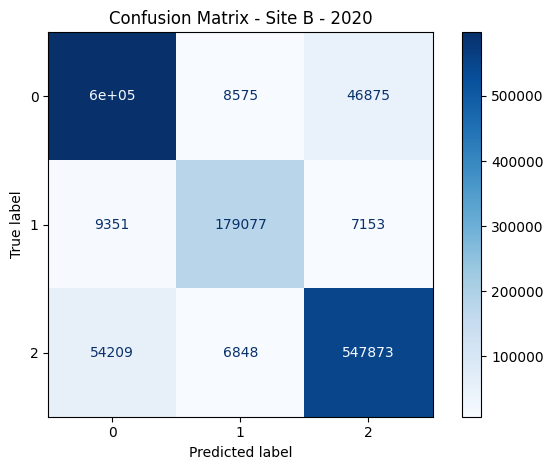


Saved labeled data for bvsb to true_BCNN_selected_data/true_BCNN_data_bvsb.npz


In [33]:
for name, query_func in sampling_strategies.items():
    print(f"\n======================")
    print(f" Running strategy: {name.upper()} ")
    print(f"======================")    

    # Re-initializing the model for each strategy
    model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
    ckpt = torch.load('/kaggle/input/b_cnn/pytorch/default/1/BCNN.pth', map_location='cpu')

    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        state = ckpt['model_state_dict']
    else:
        state = ckpt
    
    new_state = {}
    for k, v in state.items():
        if k.startswith("_orig_mod."):
            new_state[k.replace("_orig_mod.", "")] = v
        else:
            new_state[k] = v
    model.load_state_dict(new_state, strict=True)

    labeled_pool = strategy_pools[name]["labeled"]
    unlabeled_pool = strategy_pools[name]["unlabeled"]
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    history = strategy_histories[name]

    # Training on initial labeled samples
    initial_labeled = set(np.random.choice(list(unlabeled_pool), INITIAL_LABELED, replace=False))
    labeled_pool.update(initial_labeled)
    unlabeled_pool.difference_update(initial_labeled)
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    train_dataset = Conv1dDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

     # ===== Class weights =====
    all_labels = []
    for _, y_batch in train_loader:
        all_labels.append(y_batch.numpy())
    
    all_labels = np.concatenate(all_labels)
    classes = np.unique(all_labels)
    class_weights_np = compute_class_weight(class_weight='balanced',
                                            classes=classes, y=all_labels)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
    class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
    print("Class weights:", class_weights)

    #  Train + Evaluate
    print(f'\n-> Training on {INITIAL_LABELED} initially labeled samples ')
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    
    train_losses, train_accs = train(model, train_dataset, train_loader, optimizer, class_weights, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
    loss, acc, kappa, per_class_f1, avg_f1, _ = evaluate(model, val_dataloader, class_weights, T, DEVICE)
    scheduler.step(loss)

    
    print("Per-class F1 scores:", per_class_f1)
    print(f"Validation Accuracy: {acc * 100:.2f}%")
    print(f"Validation Loss: {loss:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f'Kappa: {kappa:.4f}')

    history["rounds"].append(0)
    history["num_labeled"].append(len(labeled_pool))
    history["train_accuracy"].append(train_accs[-1])
    history["train_loss"].append(train_losses[-1])
    history["val_accuracy"].append(acc)
    history["val_loss"].append(loss)
    history["avg_f1"].append(avg_f1)
    history["per_class_f1"].append(per_class_f1.tolist())
    history["kappa"].append(kappa)
    

    for round_num in range(1, AL_ROUNDS + 1):
        print(f"\n--- Round {round_num} [{name}] ---")
        
        # 1. Query k samples
        queried_indices = query_func(
            X=X_train,
            model=model,
            k=QUERY_SIZE,
            device=DEVICE,
            unlabeled_pool=unlabeled_pool,
            T = T
        )
    
        # 2. Update pools
        new_indices = set(queried_indices) - labeled_pool  # avoid duplication
        labeled_pool.update(new_indices)
        unlabeled_pool.difference_update(new_indices)
        print('Length of Labeled Pool:', len(labeled_pool))
        print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
        # 3. Build train loader
        train_dataset = Conv1dDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # 4. Train + Evaluate
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    
        train_losses, train_accs = train(model, train_dataset, train_loader, optimizer, class_weights, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
        loss, acc, kappa, per_class_f1, avg_f1, _ = evaluate(model, val_dataloader, class_weights, T, DEVICE)
        scheduler.step(loss)
        
        print("Per-class F1 scores:", per_class_f1)
        print(f"Validation Accuracy: {acc * 100:.2f}%")
        print(f"Validation Loss: {loss:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f'Kappa: {kappa:.4f}')
    
        history["rounds"].append(round_num)
        history["num_labeled"].append(len(labeled_pool))
        history["train_accuracy"].append(train_accs[-1])
        history["train_loss"].append(train_losses[-1])
        history["val_accuracy"].append(acc)
        history["val_loss"].append(loss)
        history["avg_f1"].append(avg_f1)
        history["per_class_f1"].append(per_class_f1.tolist())
        history["kappa"].append(kappa)

    
    # Testing the model on test data
    loss, acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, class_weights, T, DEVICE)
    print()
    print("=" * 50)
    print(f'Test Results for Strategy {name.upper()}')
    print("=" * 50)
    print(f"Overall Accuracy: {acc * 100:.2f}%")
    print(f"Loss: {loss:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print("Per-class F1 scores:", per_class_f1)
    print(f'Kappa: {kappa}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()
    print("=" * 50)
    print ()

    # Saving the Labeled Pool for each strategy
    save_dir = "true_BCNN_selected_data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    
    data_file = os.path.join(save_dir, f"true_BCNN_data_{name}.npz")
    np.savez(
        data_file,
        X=X_train[list(labeled_pool)],
        y=y_train[list(labeled_pool)]
    )
    
    print(f"Saved labeled data for {name} to {data_file}")

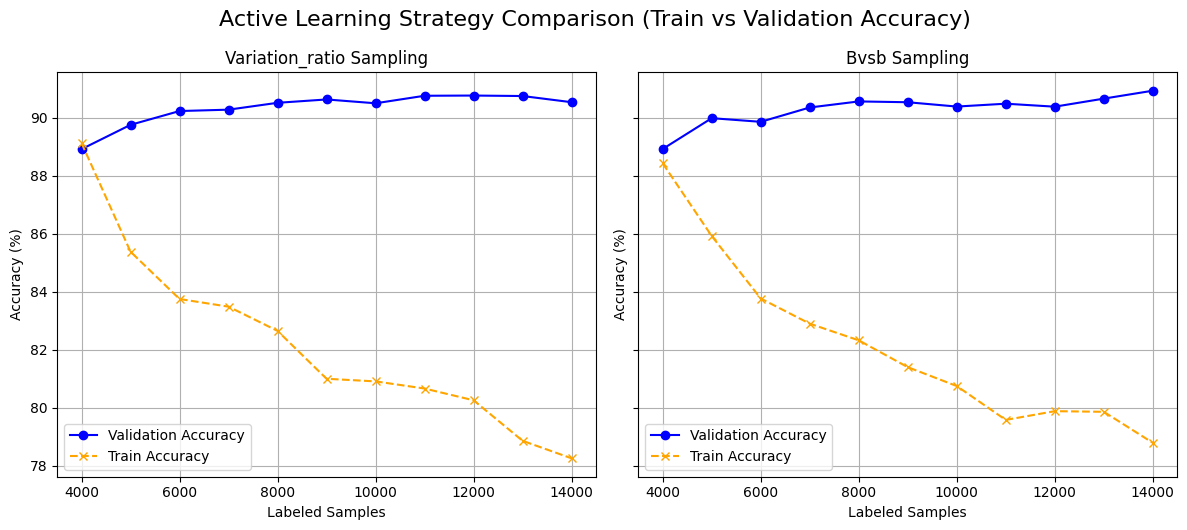

In [34]:
# Accuracy Plot: Train vs Val
n = len(sampling_strategies)  
fig, axs = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_accs = [a * 100 for a in history["val_accuracy"]]
    train_accs = [a * 100 for a in history["train_accuracy"]]

    axs[i].plot(history["num_labeled"], val_accs, marker="o", label="Validation Accuracy", color="blue")
    axs[i].plot(history["num_labeled"], train_accs, marker="x", linestyle="--", label="Train Accuracy", color="orange")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Accuracy)", fontsize=16, y=1.05)
plt.show()

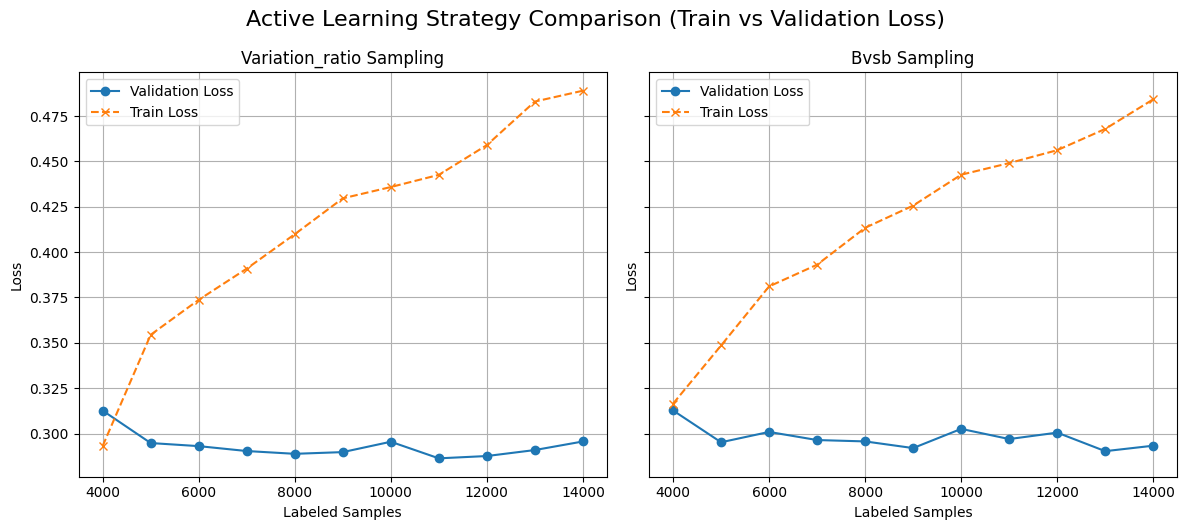

In [35]:
# Loss Plot: Train vs Val
n = len(sampling_strategies)  
fig, axs = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_loss = [l for l in history["val_loss"]]
    train_loss = [l for l in history["train_loss"]]

    axs[i].plot(history["num_labeled"], val_loss, marker="o", label="Validation Loss")
    axs[i].plot(history["num_labeled"], train_loss, marker="x", linestyle="--", label="Train Loss")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Loss")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Loss)", fontsize=16, y=1.05)
plt.show()

## Saving the Results

In [36]:
# After your active learning loop finishes for all strategies:
output_file = "active_learning_history_trueBCNN.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for strategy_name, history in strategy_histories.items():
        # Convert history dict to DataFrame
        df = pd.DataFrame({
            "round": history["rounds"],
            "num_labeled": history["num_labeled"],
            "train_accuracy": history["train_accuracy"],
            "train_loss": history["train_loss"],
            "val_accuracy": history["val_accuracy"],
            "val_loss": history["val_loss"],
            "avg_f1": history["avg_f1"],
            "kappa": history["kappa"],
            # store per-class f1 as string so Excel can hold it
            "per_class_f1": [",".join(map(str, f1)) for f1 in history["per_class_f1"]]
        })

        # Save each strategy history in its own sheet
        df.to_excel(writer, sheet_name=strategy_name, index=False)

print(f"Saved history of all strategies to {output_file}")

Saved history of all strategies to active_learning_history_trueBCNN.xlsx


In [37]:
# Zip the folder
shutil.make_archive("true_BCNN_selected_data", 'zip', "true_BCNN_selected_data")

'/kaggle/working/true_BCNN_selected_data.zip'

In [38]:
FileLink("true_BCNN_selected_data.zip")

/kaggle/working/true_BCNN_selected_data.zip

<hr>